## 1. Постановка задачи

**Цель** — разработать модель машинного обучения, которая поможет обрабатывать объявления и увеличит число сделок и прибыль агентства.

1. Провести разведывательный анализ и предварительную подготовку данных. 
2. Определить ключевые факторы, оказывающие влияние на ценность объектов недвижимости.
3. Построить модель для оценки стоимости объектов недвижимости.
4. Создать компактный веб-сервис, который будет получать информацию о выставленных на продажу объектах и предоставлять прогнозируемую стоимость.

## 2. Знакомство и расширение данных

In [44]:
import numpy as np
import pandas as pd
import re
import ast
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_classif, f_regression
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import median_absolute_error
import optuna
from sklearn import ensemble
from sklearn import metrics
from sklearn.linear_model import Ridge
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import Lasso
from sklearn.metrics import r2_score
from scipy import stats
from scipy.stats import normaltest
from scipy.stats import randint, uniform
import xgboost as xgb
import time
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
import joblib
import math
from sklearn.model_selection import RandomizedSearchCV
from tqdm.notebook import tqdm
import plotly.express as px
import us

In [5]:
data = pd.read_csv("data.csv")

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 377185 entries, 0 to 377184
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   status        337267 non-null  object
 1   private pool  4181 non-null    object
 2   propertyType  342452 non-null  object
 3   street        377183 non-null  object
 4   baths         270847 non-null  object
 5   homeFacts     377185 non-null  object
 6   fireplace     103114 non-null  object
 7   city          377151 non-null  object
 8   schools       377185 non-null  object
 9   sqft          336608 non-null  object
 10  zipcode       377185 non-null  object
 11  beds          285903 non-null  object
 12  state         377185 non-null  object
 13  stories       226469 non-null  object
 14  mls-id        24942 non-null   object
 15  PrivatePool   40311 non-null   object
 16  MlsId         310305 non-null  object
 17  target        374704 non-null  object
dtypes: object(18)
memory usa

Описание данных:
* 'status' — статус продажи;
* 'private pool' и 'PrivatePool' — наличие собственного бассейна;
* 'propertyType' - тип объекта недвижимости;
* 'street' - адрес объекта;
* 'baths' - количество ванных комнат;
* 'homeFacts' - сведения о строительстве объекта (содержит несколько типов сведений, влияющих на оценку объекта);
* 'fireplace' - наличие камина;
* 'city' - город;
* 'schools' - сведения о школах в районе;
* 'sqft' - площадь в футах;
* 'zipcode' - почтовый индекс;
* 'beds' - количество спален;
* 'state' - штат;
* 'stories' - количество этажей;
* 'mls-id' и 'MlsId' - идентификатор MLS (Multiple Listing Service, система мультилистинга);
* 'target' - цена объекта недвижимости (целевой признак, который необходимо спрогнозировать).

In [7]:
data.head()

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target
0,Active,NaN,Single Family Home,240 Heather Ln,3.5,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",Gas Logs,Southern Pines,"[{'rating': ['4', '4', '7', 'NR', '4', '7', 'N...",2900,28387,4,NC,NaN,NaN,NaN,611019,"$418,000"
1,for sale,NaN,single-family home,12911 E Heroy Ave,3 Baths,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",NaN,Spokane Valley,"[{'rating': ['4/10', 'None/10', '4/10'], 'data...","1,947 sqft",99216,3 Beds,WA,2.0,NaN,NaN,201916904,"$310,000"
2,for sale,NaN,single-family home,2005 Westridge Rd,2 Baths,"{'atAGlanceFacts': [{'factValue': '1961', 'fac...",yes,Los Angeles,"[{'rating': ['8/10', '4/10', '8/10'], 'data': ...","3,000 sqft",90049,3 Beds,CA,1.0,NaN,yes,FR19221027,"$2,895,000"
3,for sale,NaN,single-family home,4311 Livingston Ave,8 Baths,"{'atAGlanceFacts': [{'factValue': '2006', 'fac...",yes,Dallas,"[{'rating': ['9/10', '9/10', '10/10', '9/10'],...","6,457 sqft",75205,5 Beds,TX,3.0,NaN,NaN,14191809,"$2,395,000"
4,for sale,NaN,lot/land,1524 Kiscoe St,NaN,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Palm Bay,"[{'rating': ['4/10', '5/10', '5/10'], 'data': ...",NaN,32908,NaN,FL,NaN,NaN,NaN,861745,"$5,000"


In [9]:
#посчитаем нулевые значения
for col in data.columns:
    pct_missing = np.mean(data[col].isna())
    print(f'{col} - {round(pct_missing*100)}%')

status - 11%
private pool - 99%
propertyType - 9%
street - 0%
baths - 28%
homeFacts - 0%
fireplace - 73%
city - 0%
schools - 0%
sqft - 11%
zipcode - 0%
beds - 24%
state - 0%
stories - 40%
mls-id - 93%
PrivatePool - 89%
MlsId - 18%
target - 1%


## 3. Обработка и создание новых признаков

Описание процесса предобработки данных и генерации новых признаков:

1. **Очистка и преобразование данных:** Начинаем с тщательной очистки исходного набора данных, удаляя дубликаты, исправляя ошибки ввода и стандартизируя аббревиатуры. Для каждого признака проводится индивидуальная очистка, включая преобразование текстовых данных в числовой формат, заполнение отсутствующих значений и корректировку некорректных данных.

2. **Расшифровка сокращений:** Идентифицируем сокращения и жаргонные выражения, преобразуя их в полные формы для обеспечения стандартизации данных и улучшения качества анализа.

3. **Обработка пропусков:** Пропущенные значения заполняются с использованием различных методов, таких как применение медианы или моды, что позволяет поддерживать статистическую целостность данных.

4. **Удаление выбросов:** Аномальные значения, которые могут исказить результаты анализа и моделирования, удаляются для повышения точности предсказаний.

5. **Создание новых признаков:** На основе анализа существующих данных генерируются новые признаки, которые могут значительно улучшить прогностическую способность модели. Это включает в себя выведение количественных характеристик из текстовых описаний и комбинирование различных признаков для формирования более сложных индикаторов.

Эти шаги являются ключевыми для обеспечения высокого качества данных, что напрямую влияет на эффективность и точность предиктивных моделей. Тщательный анализ и предобработка данных — это фундаментальный этап в процессе аналитики, определяющий успех последующего моделирования.

### status

In [10]:
patterns = {
    re.compile(r' / auction|.*Auction.*', re.IGNORECASE): 'Auction',
    re.compile(r'C|Option Contract.*', re.IGNORECASE): 'Contract',
    re.compile(r'.*(Conting|Ct|CT|Coming soon|Back on Market).*'): 'Contingent',
    re.compile(r"Pf|Pre-foreclosure.*", re.IGNORECASE): 'Pre Foreclosure',
    re.compile(r"(?i)Foreclos*"): 'Foreclosure',
    re.compile(r'New.*', re.IGNORECASE): 'New',
    re.compile(r'(?i).*pending.*|P|Active Option.'): 'Pending',
    re.compile(r'(?i)For sale.*'): 'for sale',
    re.compile(r'(?i).*Sold.*'): 'Sold',
    re.compile(r'Lease/*|Apartment for rent.*', re.IGNORECASE): 'for rent',
    re.compile(r'(?i).*Backup.*|Accepted|Uc|U\sUnder\sContract|.*Under.*'): 'Under Contract',
    re.compile(r'(?i).*activ.*|Re activated.*'): 'Active'
}

data['status2'] = data['status'].astype(str).apply(
    lambda x: next((replacement for pattern, replacement in patterns.items() if pattern.match(x)), x)
)

# Находим моду признака "status2"
mode_status = data['status2'].mode()[0]

# Заменим пустых значений на моду
data['status2'].fillna(mode_status, inplace=True)
data['status2'] = data['status2'].replace('nan', mode_status)

# Удалим вспомогательные столбцы
data = data.drop(['status'], axis=1)
data['status2'].value_counts().sort_index()

status2
Active                  105712
Auction                   3070
Back On Market               6
Contingent                 194
Contract                  1317
Due Diligence Period        27
Foreclosure               7228
Listing Extended            28
New                       6165
Pending                   7416
Pre Foreclosure           2123
Sold                       289
Under Contract            3715
for rent                   406
for sale                239489
Name: count, dtype: int64

### Street

In [11]:
# Заменим пустые значения на моду признака
data['street'].fillna(data['street'].mode()[0], inplace=True)

### propertyType

In [12]:
data['propertyType'].value_counts()

propertyType
single-family home                                             92206
Single Family                                                  62869
Single Family Home                                             31728
condo                                                          25968
lot/land                                                       20552
                                                               ...  
Custom, Elevated, Other                                            1
Contemporary, Farmhouse                                            1
2 Stories, Traditional, Mediterranean, Texas Hill Country          1
1 Story, Contemporary, Traditional, Mediterranean                  1
Bilevel, Converted Dwelling, Loft with Bedrooms, Condo/Unit        1
Name: count, Length: 1280, dtype: int64

Данный скрипт оптимизирует классификацию данных по типам жилья в колонке 'propertyType', применяя регулярные выражения для объединения различных вариантов описаний в три ключевые категории: 'multi-family', 'Manufactured housing' и 'one-to-four'. После этого процесса формируется новая колонка 'propertyType_New', включающая в себя данные категории. Для предотвращения повторений и для более четкой структуры данных, первоначальная колонка 'propertyType' удаляется из набора данных.

In [13]:
# Паттерны для оптимизации
patterns = {
    r"(?i)\b(multi|condo|Condominium|Townhome|row home|co-op|coop|apartment|High Rise|Flat)\b": "multi-family",
    r"(?i)\b(Duplex|Triplex|Townhouse|townhouse|Cooperative|Penthouse|Bungalow|Multiple)\b": "multi-family",
    r"(?i)\b(Manufactured|Mfd|Mobile)\b": "Manufactured housing",
    r"(?i)\b(Single|story|Stories|transitional|Land|Ranch|Ranches|Contemporary|Colonial|Residential|Traditional|Garden Home|Cape Cod|Spanish|Mediterranean|Cluster Home|Florida|Tudor|SingleFamilyResidence|Craftsman|Cottage)\b": "one-to-four"
}

# Оптимизация столбца 'propertyType' с помощью паттернов
data['propertyType'] = data['propertyType'].replace(patterns, regex=True)

# Выведем совпадающие значения из списка в новый признак
keywords = ["multi-family", "Manufactured housing", "one-to-four"]
data['propertyType_New'] = data['propertyType'].apply(
    lambda x: next((keyword for keyword in keywords
                    if re.search(keyword, str(x), re.IGNORECASE)), 'one-to-four')).fillna('')
                    
# Удалим вспомогательные столбцы
data = data.drop(['propertyType'], axis=1)


In [14]:
data['propertyType_New'].value_counts()

propertyType_New
one-to-four             283434
multi-family             90170
Manufactured housing      3581
Name: count, dtype: int64

### bath

In [15]:
# Извлечение только целых чисел из признака 'baths'
data['baths'] = data['baths'].str.extract(r'(\d+)').astype(float)
# Заменим все пустые значения на 0
data['baths'].fillna(0, inplace=True)
# Заменим тип данных на числовой
data['baths'] = data['baths'].astype(int)

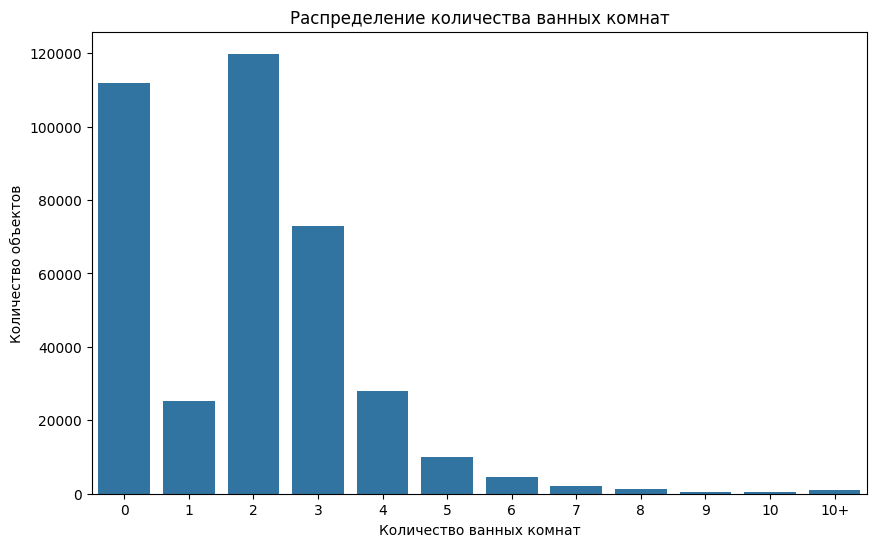

In [16]:
# Создаем категории для значений больше 10
baths_grouped = data['baths'].apply(lambda x: '10+' if x > 10 else str(x))

# Укажим желаемый порядок категорий
desired_order = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '10+']

# Подсчитаем количество объектов в каждой категории и отсортируйте их
baths_counts = baths_grouped.value_counts().loc[desired_order]

# Визуализация
plt.figure(figsize=(10, 6))
sns.barplot(x=baths_counts.index, y=baths_counts.values)
plt.title('Распределение количества ванных комнат')
plt.xlabel('Количество ванных комнат')
plt.ylabel('Количество объектов')
plt.show()


### city

Для идентификации самого распространенного города (city) в пределах каждого штата (state) в нашем датасете, мы проводим группировку данных по полю state и используем функцию mode из библиотеки pandas для определения моды по city. Результаты сохраняются в серии state_mode, которая затем трансформируется в DataFrame для удобства обработки. Колонкам присваиваются имена ['state', 'mode_city']. Далее, мы интегрируем новый столбец mode_city в основной DataFrame data, используя объединение по ключу state. Все отсутствующие значения (NaN), пустые строки и строки с "--" в колонке city заменяются соответствующими значениями из mode_city. После выполнения замены, столбец mode_city удаляется из основного DataFrame.

Завершая процесс, мы создаем картографическую визуализацию, отображающую количество объектов недвижимости в различных штатах.

In [17]:
# Вывод значений моды city для каждого state
state_mode = data.groupby(['state'])['city'].agg(pd.Series.mode)

# Преобразование серии в датафрейм
state_mode = state_mode.reset_index()
state_mode.columns = ['state', 'mode_city']

# Объединение по ключу 'state' и добавление нового признака 'mode_city'
data = pd.merge(data, state_mode, on='state', how='left')

# Заменим лишние и пустые значения на моду по штату
data.loc[(data['city'].isna()) | (data['city'] == " ")
| (data['city'] == "--"), 'city'] = data['mode_city']

# Удалим вспомогательные столбцы
data = data.drop(['mode_city'], axis=1)

In [19]:
# Преобразование аббревиатур в полные названия
data['state_full'] = data['state'].apply(lambda x: us.states.lookup(x).name if us.states.lookup(x) else x)

# После этого мы можем использовать 'state_full' для сопоставления с геоданными
# Генерация количества объектов недвижимости по штатам
state_counts = data['state'].value_counts().reset_index()
state_counts.columns = ['state', 'property_count']

# Визуализация данных на карте США
fig = px.choropleth(
    state_counts,
    locations='state',  # Это поле сокращений штатов в нашем DataFrame
    locationmode='USA-states',  # Режим отображения использует сокращения штатов США
    color='property_count',  # Поле с данными для отображения
    scope="usa",  # Ограничиваем карту только США
    title='Количество объектов недвижимости по штатам'
)

fig.show()


### homeFacts

Этот скрипт выполняет десериализацию и обогащение данных о недвижимости в столбце 'homeFacts':

1. **Десериализация:** Строки JSON в 'homeFacts' преобразуются в словари Python через ast.literal_eval, переводя формат данных из текстового в структурированный.

2. **Извлечение и создание новых признаков:** На основе ключей в десериализованных словарях, таких как 'YearBuilt', 'RemodeledYear', 'Heating', 'Cooling', 'Parking', 'LotSize', и 'PricePerSqft', формируются новые столбцы. Это улучшает структурирование и детализацию информации о недвижимости.

3. **Удаление старого столбца 'homeFacts':** После извлечения значимой информации, колонка 'homeFacts' удаляется, что способствует упрощению данных и повышению их читаемости.

Применение этих методов значительно улучшает качество данных, обогащая их деталями, необходимыми для глубокого анализа и точного моделирования.

In [20]:
# Десериализуем содержимое признака 'homeFacts'
data['homeFacts'] = data['homeFacts'].apply(ast.literal_eval)

# Извлекаем значения по ключу 'factLabel'
fact_labels = [item['factLabel'] for item in data['homeFacts'][0]['atAGlanceFacts']]
# Выводим заголовки списком
print(fact_labels)

['Year built', 'Remodeled year', 'Heating', 'Cooling', 'Parking', 'lotsize', 'Price/sqft']


In [21]:
# Создадим новые признаки на основе десериализованных значений
data['YearBuilt'] = data['homeFacts'].apply(lambda x: x['atAGlanceFacts'][0]['factValue'])
data['RemodeledYear'] = data['homeFacts'].apply(lambda x: x['atAGlanceFacts'][1]['factValue'])
data['Heating'] = data['homeFacts'].apply(lambda x: x['atAGlanceFacts'][2]['factValue'])
data['Cooling'] = data['homeFacts'].apply(lambda x: x['atAGlanceFacts'][3]['factValue'])
data['Parking'] = data['homeFacts'].apply(lambda x: x['atAGlanceFacts'][4]['factValue'])
data['LotSize'] = data['homeFacts'].apply(lambda x: x['atAGlanceFacts'][5]['factValue'])
data['PricePerSqft'] = data['homeFacts'].apply(lambda x: x['atAGlanceFacts'][6]['factValue'])

# Удалим старый столбец
data = data.drop(['homeFacts'], axis=1)

### homeFacts очистка

Этот скрипт содержит последовательность операций для очистки и нормализации данных в различных колонках, связанных с недвижимостью:

1. **YearBuilt**: Осуществляет очистку колонки 'YearBuilt' от ошибочных или аномальных значений (как, например, пустые строки или 'No Data'), заменяя их на `None`, что в дальнейшем преобразуется в `NaN` в Pandas.

2. **RemodeledYear**: Переводит все значения, равные нулю, в колонке 'RemodeledYear' в `NaN`, тем самым исключая неверные или отсутствующие данные о годе реновации.

3. **Heating, Cooling, Parking**: Нормализует категориальные данные 'Heating', 'Cooling' и 'Parking', заменяя определённые строки на 0 и все остальные на 1, превращая их в бинарные индикаторы (0 или 1). Пустые значения также преобразуются в 0.

4. **LotSize, PricePerSqft**: Выделяет числовые данные из строковых колонок 'LotSize' и 'PricePerSqft', преобразуя их в числовой формат и удаляя символы, не являющиеся числами. Это обеспечивает единообразие данных для анализа размера участка и стоимости за квадратный фут.

Применение этих операций повышает качество данных, делая их более пригодными для аналитической работы и моделирования.

In [22]:
# Создадим список значений для поиска
values_to_replace = ['', '559990649990', 'No', '1', 'No Data']
# Заменим значения из списка
data['YearBuilt'] = np.where(data['YearBuilt'].isin(values_to_replace), None, data['YearBuilt'])

# заменим 0 значения на NaN
data['RemodeledYear'] = np.where(data['RemodeledYear'] == 0, np.nan, data['RemodeledYear']).astype('object')

In [23]:
# Создадим список значений для поиска
values_to_replace = ['', 'No Data', 'None']
# Заменим значения из списка на 0, а остальные на 1
data['Heating'] = data['Heating'].replace(values_to_replace, 0).replace('[^0]', 1, regex=True)
data['Cooling'] = data['Cooling'].replace(values_to_replace, 0).replace('[^0]', 1, regex=True)
data['Parking'] = data['Parking'].replace(values_to_replace, 0).replace('[^0]', 1, regex=True)

# Заменим пустые значения на 0
data['Heating'] = data['Heating'].fillna(0).astype(int)
data['Cooling'] = data['Cooling'].fillna(0).astype(int)
data['Parking'] = data['Parking'].fillna(0).astype(int)
data['Parking'] = data['Parking'].replace('0', 0).astype(int)

In [24]:
# извлечем из признаков только числа
data['LotSize'] = data['LotSize'].str.extract('(\d+.\d+|\d+)', expand=False)
data['PricePerSqft'] = data['PricePerSqft'].str.extract('(\d+.\d+|\d+)', expand=False)

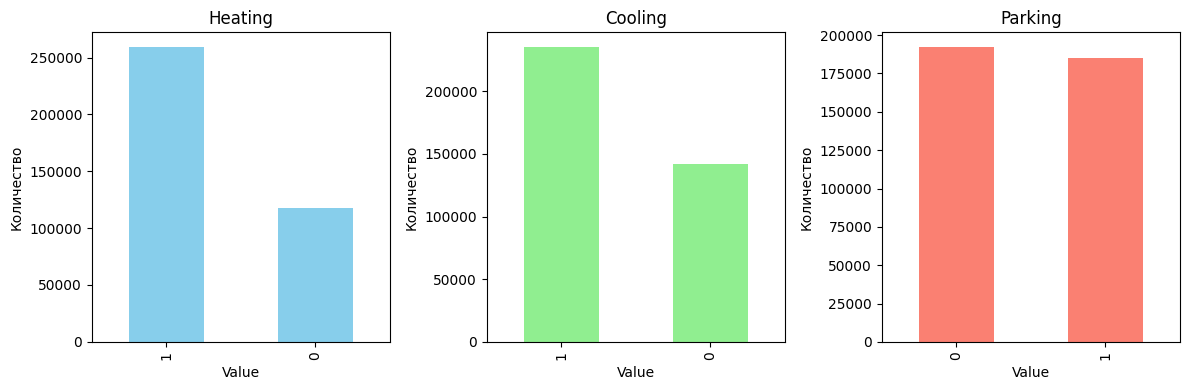

In [25]:
# Создаем график для признака Heating
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
data['Heating'].value_counts().plot(kind='bar', color='skyblue')
plt.title('Heating')
plt.xlabel('Value')
plt.ylabel('Количество')

# Создаем график для признака Cooling
plt.subplot(1, 3, 2)
data['Cooling'].value_counts().plot(kind='bar', color='lightgreen')
plt.title('Cooling')
plt.xlabel('Value')
plt.ylabel('Количество')

# Создаем график для признака Parking
plt.subplot(1, 3, 3)
data['Parking'].value_counts().plot(kind='bar', color='salmon')
plt.title('Parking')
plt.xlabel('Value')
plt.ylabel('Количество')

# Отображаем графики
plt.tight_layout()
plt.show()


На графиках представлен анализ наличия трех ключевых удобств в недвижимости: систем отопления (Heating), охлаждения (Cooling) и парковочных мест (Parking). Показатель "1" свидетельствует о наличии удобства, в то время как "0" указывает на его отсутствие.

1. **Системы отопления (Heating)**: Подавляющее большинство объектов оснащено системами отопления, что подтверждается преобладанием столбцов с показателем "1" над столбцами с показателем "0".

2. **Системы охлаждения (Cooling)**: В сравнении с системами отопления, количество объектов с системами охлаждения значительно меньше, что видно по меньшему количеству столбцов с показателем "1".

3. **Парковочные места (Parking)**: Наличие парковочных мест распределено более равномерно, с примерно одинаковым количеством объектов, имеющих и не имеющих парковку, что отражается в схожей высоте столбцов "1" и "0".

Эти данные предоставляют визуальное представление о частоте встречаемости различных удобств в недвижимости, что может играть ключевую роль в принятии решений для покупателей и инвесторов. 

### schools

Мы проводим анализ данных о школах, интегрированных в колонку 'schools' нашего датафрейма. Извлекаем подробную информацию о школах, на основе которой формируем новые атрибуты: оценку школы, её удалённость и общее число школ в районе. Далее вычисляем среднее и минимальное расстояние до ближайших учебных заведений, а также средний рейтинг школ. После завершения этих операций, мы убираем из датафрейма все вспомогательные колонки, использованные в процессе. 

In [26]:
# Десериализуем содержимое признака 'homeFacts'
data['schools'] = data['schools'].apply(ast.literal_eval)

# Создадим новые признаки из признака 'schools' и применить функцию lambda
data['rating'] = data['schools'].apply(lambda x: x[0]['rating'])
data['Distance'] = data['schools'].apply(lambda x: x[0]['data']['Distance'])
data['name_school'] = data['schools'].apply(lambda x: x[0]['name'])

# Создадим признак с количеством школ
data['school_count'] = data['name_school'].apply(len)
# Выислим сумму расстояний до школ
data['sum_distance'] = data['Distance'].apply(lambda x: sum(float(re.findall(
    r'\d+\.\d+', val)[0]) for val in x if re.findall(r'\d+\.\d+', val)) if x and
                                              any(re.findall(r'\d+\.\d+', val) for val in x) else None)
# Посчитаем среднюю дистанцию до школы
data['Avr_distance'] = data['sum_distance'] / data['school_count']

In [27]:
# Извлечение цифр и вычисление среднего расстояния до школы
data['MinDistance'] = data['Distance'].apply(
    lambda x: min(float(re.findall(r'\d+\.\d+', val)[0]) for val in x if re.
                  findall(r'\d+\.\d+', val)) if x and any(re.findall(r'\d+\.\d+',
                                                                     val) for val in x)
                  else None
)

# Функция для обработки и вычисления значения рейтинга
def calculate_rating(row):
    ratings = []
    for val in row:
        if re.match(r'^[\d./]+$', val):
            val = re.sub(r'/10$', '', val)
            try:
                ratings.append(float(val))
            except ValueError:
                pass
    return np.mean(ratings) if ratings else np.nan
    ratings

# Применение функции calculate_rating к столбцу 'rating' и создание нового столбца 'AverageRating'
data['AverageRating'] = data['rating'].apply(calculate_rating)

# Удалим вспомогательные столбцы
data = data.drop(['sum_distance', 'schools', 'rating', 'Distance', 'name_school'], axis=1)

Построим графики для рейтинга

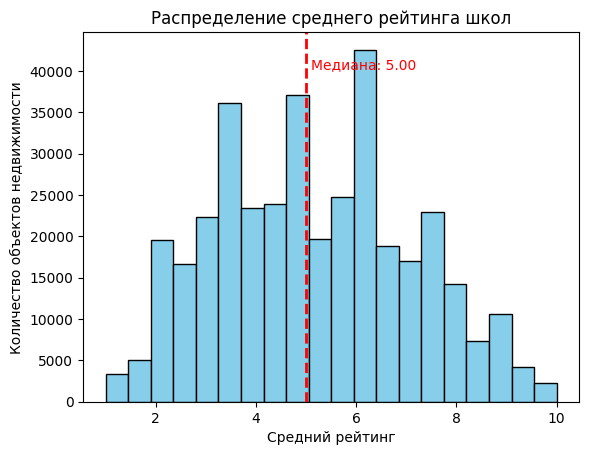

In [28]:
# Гистограмма распределения среднего рейтинга школ
plt.hist(data['AverageRating'].dropna(), bins=20, color='skyblue', edgecolor='black')

# Вычисление медианного значения среднего рейтинга
median_rating = data['AverageRating'].median()

# Добавление пунктирной линии для медианного значения
plt.axvline(median_rating, color='red', linestyle='dashed', linewidth=2)

# Добавление текста с медианным значением
plt.text(median_rating + 0.1, plt.ylim()[1]*0.9, f'Медиана: {median_rating:.2f}', color='red')

plt.title('Распределение среднего рейтинга школ')
plt.xlabel('Средний рейтинг')
plt.ylabel('Количество объектов недвижимости')
plt.show()

Гистограмма отображает частоту встречаемости школ с разными уровнями среднего рейтинга, ассоциированных с объектами недвижимости. Большинство недвижимости связано со школами, имеющими средний рейтинг около 5, что свидетельствует о стандартном уровне данных учебных заведений. Пунктирная линия на графике демонстрирует медианное значение, разделяющее школы на две группы: с рейтингом выше и ниже 5. Это говорит о тенденции к среднему качеству образовательных услуг среди представленных объектов недвижимости. 

In [29]:
# Группировка данных по штатам и расчет среднего рейтинга школ для каждого штата
state_avg_rating = data.groupby('state')['AverageRating'].mean().reset_index()

# Визуализация данных на карте США с использованием Plotly
fig = px.choropleth(
    state_avg_rating,  # Используем подготовленный DataFrame
    locations='state',  # Используем полные названия штатов для сопоставления
    locationmode='USA-states',  # Указываем, что locations основаны на названиях штатов США
    color='AverageRating',  # Значение, которое будет использоваться для раскраски штатов
    color_continuous_scale='Viridis',  # Шкала цветов для раскраски
    scope='usa',  # Ограничение карты США
    title='Средний рейтинг школ по штатам',  # Заголовок карты
    labels={'AverageRating': 'Средний рейтинг школ'}  # Подпись для легенды
)

# Отображение карты
fig.show()


Карта США демонстрирует средний рейтинг школ по каждому штату. На карте видно, что информация о рейтинге отсутствует для некоторых штатов, обозначенных без цвета. В штатах, где присутствуют данные, применены оттенки, отражающие средний рейтинг школ в соответствии с легендой справа. К примеру, светлый цвет Монтаны говорит о выше среднего рейтинга школ, в то время как тёмная окраска Пенсильвании указывает на более низкий уровень рейтинга школ в этом штате. 

### sqft

In [30]:
# Выведем только числа из признака 'sqft'
data['sqft'] = data['sqft'].apply(lambda x: re.sub(r'\D', '', str(x)))
data['sqft'] = data['sqft'].replace('', np.nan)
data['sqft'] = data['sqft'].dropna().astype(int)

# Замена пустых значений в столбце 'sqft' на медианное значение этого столбца
data['sqft'].fillna(data['sqft'].median(), inplace=True)

data['sqft'].head()

0    2900.0
1    1947.0
2    3000.0
3    6457.0
4    1800.0
Name: sqft, dtype: float64

### zipcode

In [31]:
data['zipcode'].mode()[0]

'32137'

В процессе обработки данных для колонки 'zipcode', первоначально происходит извлечение числовых значений из строк, представляющих индексы. Далее, значения '0' и '00000' конвертируются в NaN, а все отсутствующие данные заполняются наиболее часто встречающимся значением, или модой. В завершение, числовые данные трансформируются в формат целых чисел, что упрощает последующий анализ и помогает предотвратить возможные ошибки, связанные с почтовыми индексами. 

In [32]:
# Функция для извлечения числового значения из строки индекса
def extract_zipcode_number(zipcode):
    match = re.match(r'^(\d+)-?', str(zipcode))  # Ищем последовательность цифр от начала строки до символа разделения '-'
    return match.group(1) if match else np.nan  # Возвращаем найденное значение или NaN

# Применение функции к столбцу
data['zipcode'] = data['zipcode'].apply(extract_zipcode_number)

# Замена значений '0' и '00000' на NaN
data['zipcode'].replace({'0': np.nan, '00000': np.nan}, inplace=True)

# Заполнение пропущенных значений модой
data['zipcode'].fillna(data['zipcode'].mode()[0], inplace=True)

# Преобразование столбца в int64
data['zipcode'] = data['zipcode'].astype('int64')

# Подсчет пропущенных значений
missing_values = data['zipcode'].isnull().sum()
print("Количество пропусков в столбце 'zipcode':", missing_values)

Количество пропусков в столбце 'zipcode': 0


### target

В представленном коде осуществляется очистка целевой переменной 'target' путём исключения символов, не являющихся числами, и приведения оставшихся значений к числовому типу. Для выявления и удаления выбросов применяется функция outliers_iqr, работающая на основе межквартильного размаха (IQR), что позволяет отсеивать аномальные данные. Завершающим этапом является фильтрация, удаляющая значения целевой переменной, которые не достигают заданного минимального порога, после чего проводится дополнительный анализ выбросов с использованием обновлённой функции detect_outliers_IQR. 

In [33]:
data['target'] = data['target'].apply(lambda x: re.sub(r'\D', '', str(x)))
data['target'] = data['target'].replace('', np.nan)
data['target'] = data['target'].dropna().astype(float)

In [34]:
# уберем значения менее 100 по признаку
data = data[data['target'] > 110]

# Обновленная функция для определения выбросов при помощи IQR
def detect_outliers_IQR(data, feature, threshold=1.5):
    Q1 = np.percentile(data[feature], 25)
    Q3 = np.percentile(data[feature], 75)
    IQR = Q3 - Q1
    lower_bound = Q1 - (threshold * IQR)
    upper_bound = Q3 + (threshold * IQR)
    outliers = (data[feature] < lower_bound) | (data[feature] > upper_bound)
    
    # Чистые данные (не выбросы)
    clean_data = data[~outliers]  # отбираем данные, которые не являются выбросами
    
    print("Число выбросов:", outliers.sum())
    print("Число чистых данных:", clean_data.shape[0])
    
    return outliers, clean_data

# Применим функцию к целевому признаку 'target' в вашем датафрейме 'data'
outliers, clean_data = detect_outliers_IQR(data, 'target')

# Выведем первые несколько строк чистых данных для оценки
print(clean_data.head())
data = clean_data.copy()

Число выбросов: 38176
Число чистых данных: 336506
  private pool             street  baths fireplace            city    sqft  \
0          NaN     240 Heather Ln      3  Gas Logs  Southern Pines  2900.0   
1          NaN  12911 E Heroy Ave      3       NaN  Spokane Valley  1947.0   
4          NaN     1524 Kiscoe St      0       NaN        Palm Bay  1800.0   
5          NaN  1624 S Newkirk St      0       NaN    Philadelphia   897.0   
6          NaN   552 Casanova Ct       0       NaN       POINCIANA  1507.0   

   zipcode    beds state stories  ... RemodeledYear Heating Cooling  Parking  \
0    28387       4    NC     NaN  ...                     1       0        0   
1    99216  3 Beds    WA     2.0  ...                     0       0        0   
4    32908     NaN    FL     NaN  ...                     0       0        0   
5    19145  2 Beds    PA     2.0  ...                     1       1        0   
6    34759     NaN    FL     One  ...          2006       1       1        0   



In [35]:
# Генерация средней цены недвижимости по штатам
state_avg_price = data.groupby('state')['target'].mean().reset_index()
state_avg_price.columns = ['state', 'average_price']

# Визуализация данных на карте США
fig = px.choropleth(
    state_avg_price,
    locations='state',  # Это поле с названиями штатов в нашем DataFrame
    locationmode='USA-states',  # Режим отображения использует сокращения штатов США
    color='average_price',  # Поле с данными для отображения
    color_continuous_scale='Viridis',  # Градиент цвета для значения
    scope="usa",  # Ограничиваем карту только США
    title='Средняя цена недвижимости по штатам',
    labels={'average_price': 'Средняя цена'}  # Подпись для легенды
)

# Показать фигуру
fig.show()


Исходя из анализа данных, карта, отображающая среднюю стоимость недвижимости по штатам, демонстрирует ощутимые различия в ценах на жильё по Соединённым Штатам. Самые высокие средние цены зафиксированы в таких районах, как столичный округ Колумбия (DC), штаты Калифорния (CA), Массачусетс (MA), Нью-Йорк (NY) и Орегон (OR), что может быть связано с высоким уровнем спроса и стоимости жизни, обусловленными экономическим процветанием, наличием рабочих мест и другими социально-экономическими аспектами.

Параллельно, штаты вроде Оклахомы (OK), Алабамы (AL) и другие с менее распространёнными аббревиатурами (OS, OT) показывают заметно более низкие средние цены на недвижимость. Это может отражать более низкую плотность населения, уменьшенный спрос или более доступные условия для жизни. 

In [36]:
data['target'].head()

0    418000.0
1    310000.0
4      5000.0
5    209000.0
6    181500.0
Name: target, dtype: float64

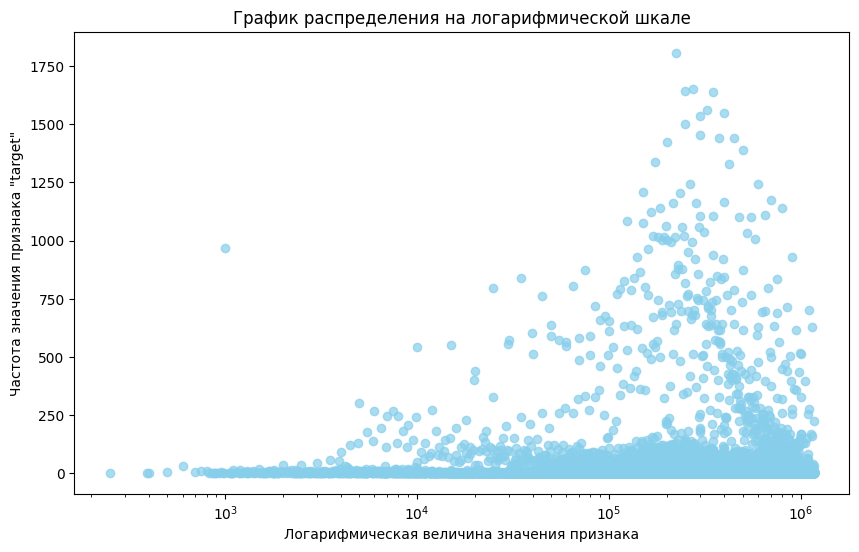

In [37]:
target_counts = data.groupby('target')['target'].agg('count')

# Построение графика распределения на логарифмической шкале
plt.figure(figsize=(10, 6))
plt.scatter(target_counts.index, target_counts, color='skyblue', alpha=0.7)
plt.xscale('log')  # Настройка масштаба оси x на логарифмический
plt.title('График распределения на логарифмической шкале')
plt.xlabel('Логарифмическая величина значения признака')
plt.ylabel('Частота значения признака "target"')
plt.show()

In [39]:
# тест Д’Агостино на нормальность распределения
stat, p = normaltest(data["target"])
alpha = 0.05
if p < alpha:
    print("Нулевая гипотеза отвергается, распределение не является нормальным")
else:
    print("Нулевая гипотеза не отвергается, распределение может быть нормальным")
    
#Чему равен вычисленный p-value?
print("p-value =", p)

Нулевая гипотеза отвергается, распределение не является нормальным
p-value = 0.0


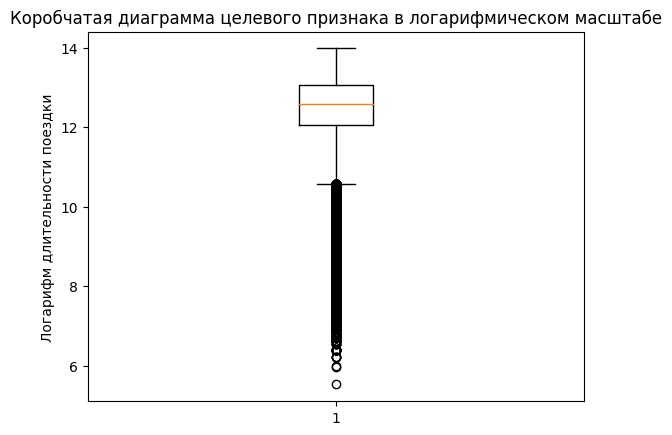

In [40]:
# логарифмируем признак
target_log = np.log(data['target']+1)

# построение коробчатой диаграммы
plt.boxplot(target_log)
plt.title("Коробчатая диаграмма целевого признака в логарифмическом масштабе")
plt.ylabel("Логарифм длительности поездки")
plt.show()

In [45]:
# Критерий Шапиро-Уилка
shapiro_test_stat, shapiro_p_value = stats.shapiro(data['target'])
print(f"Критерий Шапиро-Уилка: статистика={shapiro_test_stat}, p-значение={shapiro_p_value}")

# Критерий Колмогорова-Смирнова
ks_test_stat, ks_p_value = stats.kstest(data['target'], cdf='norm')
print(f"Критерий Колмогорова-Смирнова: статистика={ks_test_stat}, p-значение={ks_p_value}")


Критерий Шапиро-Уилка: статистика=0.922551155090332, p-значение=0.0
Критерий Колмогорова-Смирнова: статистика=1.0, p-значение=0.0


c:\Python38\lib\site-packages\scipy\stats\_morestats.py:1816: UserWarning:

p-value may not be accurate for N > 5000.



### beds

In [46]:
data['beds'].head()

0         4
1    3 Beds
4       NaN
5    2 Beds
6       NaN
Name: beds, dtype: object

В данном коде производится очистка столбца 'beds', содержащего данные о количестве спален, в том числе и некорректные записи. Инициируется создание бинарного столбца 'temp', где значение '1' обозначает присутствие неподходящих данных (например, 'acre', 'acres', 'sqft'), а '0' - наличие корректных значений. Затем формируется столбец 'beds_new', куда извлекаются числовые данные из 'beds', соответствующие критерию 'temp'. После выполнения этих шагов, первоначальный столбец 'beds' и вспомогательный 'temp' удаляются. В новом столбце 'beds_new' недостающие значения заполняются медианным значением, и столбец конвертируется в числовой формат для последующего анализа. 

In [47]:
# Создаем временный бинарный признак 'temp', где '1' - содержит мусорные значения, '0' -правильные
data['temp'] = data['beds'].astype(str).str.contains(r'acre|acres|sqft', case=False, regex=True).astype(int)

# Создаем новый признак 'beds_new', в который извлекаем только числовые значения из 'beds'
data['beds_new'] = data['beds'].str.extract(r'(\d+)')[0]

# Удаляем исходный столбец 'beds' и временный столбец 'temp'
data.drop(['beds', 'temp'], axis=1, inplace=True)

# Преобразуем 'beds_new' в числовой тип и заполняем пропущенные значения медианой
data['beds_new'] = pd.to_numeric(data['beds_new'], errors='coerce')
data['beds_new'].fillna(data['beds_new'].median(), inplace=True)

# Теперь 'data' содержит столбец 'beds_new' с числовыми значениями, готовыми для анализа
data['beds_new']


0         4.0
1         3.0
4         3.0
5         2.0
6         3.0
         ... 
377179    2.0
377181    3.0
377182    3.0
377183    8.0
377184    3.0
Name: beds_new, Length: 336506, dtype: float64

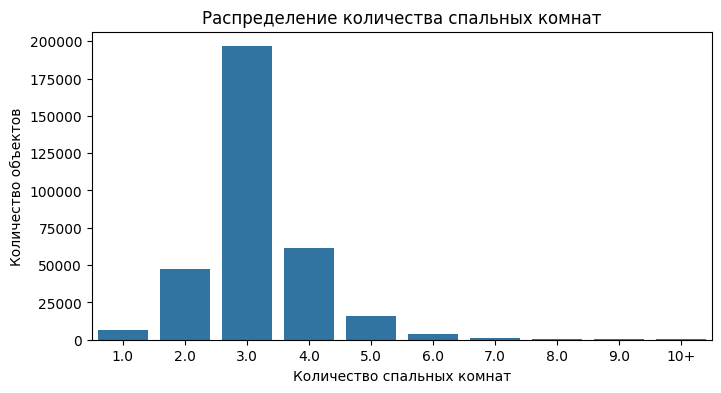

In [48]:
# Создаем категории для значений больше 10
beds_grouped = data['beds_new'].apply(lambda x: '10+' if x >= 10 else str(x))

# Укажим желаемый порядок категорий
desired_order = ['1.0', '2.0', '3.0', '4.0', '5.0', '6.0', '7.0', '8.0', '9.0', '10+']

# Подсчитаем количество объектов в каждой категории и отсортируйте их
beds_counts = beds_grouped.value_counts().loc[desired_order]

# Визуализация
plt.figure(figsize=(8, 4))
sns.barplot(x=beds_counts.index, y=beds_counts.values)
plt.title('Распределение количества спальных комнат')
plt.xlabel('Количество спальных комнат')
plt.ylabel('Количество объектов')
plt.show()

На графике видно, что большинство объектов недвижимости имеет 3 спальни

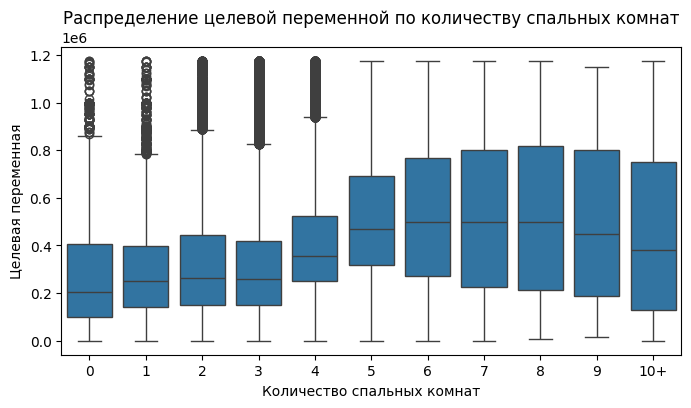

In [49]:
# Группировка значений больше 10
beds_grouped = data['beds_new'].apply(lambda x: '10+' if x >= 10 else str(int(x)))

# Указываем желаемый порядок категорий от 0 до 10 и 10+
desired_order = [str(i) for i in range(10)] + ['10+']

# Визуализация boxplot
plt.figure(figsize=(8, 4))
sns.boxplot(x=beds_grouped, y=data['target'], order=desired_order)
plt.title('Распределение целевой переменной по количеству спальных комнат')
plt.xlabel('Количество спальных комнат')
plt.ylabel('Целевая переменная')
plt.show()

Анализ представленной коробчатой диаграммы позволяет сформулировать ряд наблюдений:

1. **Распределение цен**: Наблюдается перекрытие ценовых диапазонов для жилых объектов с различным числом спален, что свидетельствует о слабой корреляции между ценой и количеством спален. Это говорит о том, что в пределах каждой категории количество спален цена может значительно колебаться.
2. **Медианные показатели**: Горизонтальные линии внутри ящиков, отображающие медианные значения, демонстрируют схожесть для разных категорий, особенно для объектов с тремя и более спальнями, что может свидетельствовать о том, что медианная стоимость объектов с большим числом спален не имеет значительных отличий.
3. **Вариативность цен**: Межквартильный размах (размеры ящиков) и длина усов иллюстрируют различия в ценовом разбросе по категориям. В таких категориях, как 0 и 10+ спален, разброс цен выглядит более значительным по сравнению с другими, что может отражать более широкий спектр предложений на рынке в этих сегментах. 

### stories

В этом коде выполняется очистка и нормализация данных в колонке 'stories', отражающей количество этажей в зданиях. Для трансформации текстовых числительных (например, "One", "Two") в их числовые эквиваленты применяются регулярные выражения. После использования данных шаблонов все оставшиеся символы, не являющиеся числами, удаляются, а затем данные конвертируются в числовой тип. Пустые ячейки заполняются значениями NaN и удаляются из набора данных. В завершение, для стандартизации данных и подготовки к анализу или моделированию, в колонке 'stories' медианное значение заполняет все пропущенные значения. 

In [50]:
# Паттерны для оптимизации
patterns = {
    r"(?i)\b(One)\b": "1",
    r"(?i)\b(Two)\b": "2",
    r"(?i)\b(Three)\b": "3",
    r"(?i)\b(Four)\b": "4",
    r"(?i)\b(Five)\b": "5",
    r"(?i)\b(.0)\b": "",
}

# Оптимизация столбца 'stories' с помощью паттернов
data['stories'] = data['stories'].replace(patterns, regex=True)

# Извлечем только цифры и преобразуем в числа
data['stories'] = data['stories'].apply(lambda x: re.sub(r'\D', '', str(x)))
data['stories'] = data['stories'].replace('', np.nan)
data['stories'] = data['stories'].dropna().astype(int)

# Замена пустых значений 'stories' на медианное значение этого столбца
data['stories'].fillna(data['stories'].median(), inplace=True)

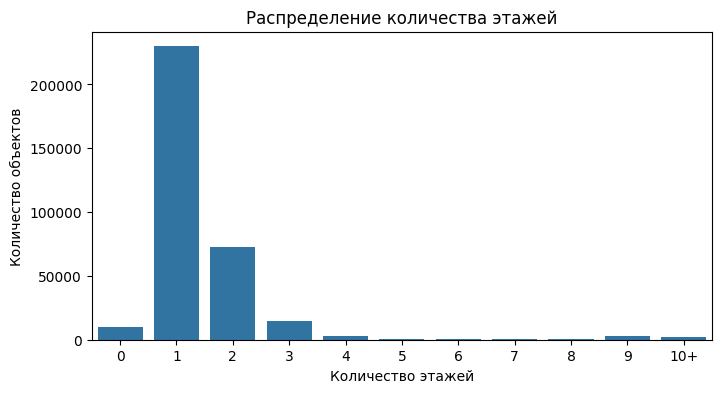

In [51]:
# Группировка значений больше 20
stories_grouped = data['stories'].apply(lambda x: '10+' if x >= 10 else str(int(x)))

# Указываем желаемый порядок категорий от 0 до 10 и 10+
desired_order = [str(i) for i in range(10)] + ['10+']

# Подсчитываем количество объектов в каждой категории с учетом заданного порядка
stories_counts = stories_grouped.value_counts().reindex(desired_order)

# Визуализация
plt.figure(figsize=(8, 4))
sns.barplot(x=stories_counts.index, y=stories_counts.values)
plt.title('Распределение количества этажей')
plt.xlabel('Количество этажей')
plt.ylabel('Количество объектов')
plt.show()

На графике видно, что в основном домовледения распределены от 0 до 4 этажей, наибольшее количество одноэтажние.

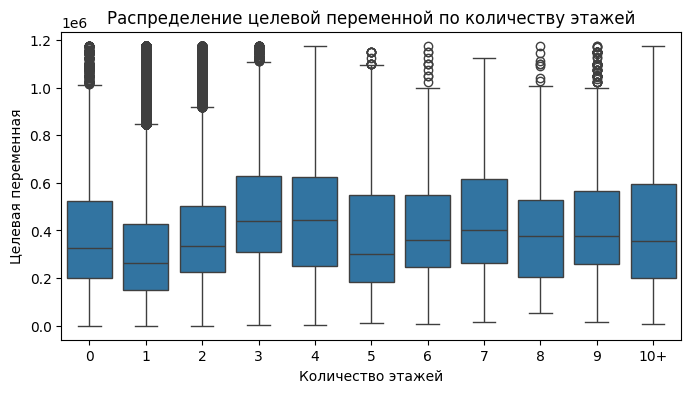

In [52]:
# Группировка значений больше 10
stories_grouped = data['stories'].apply(lambda x: '10+' if x > 10 else str(int(x)))

# Указываем желаемый порядок категорий от 0 до 10 и 10+
desired_order = [str(i) for i in range(10)] + ['10+']

# Визуализация boxplot
plt.figure(figsize=(8, 4))
sns.boxplot(x=stories_grouped, y=data['target'], order=desired_order)
plt.title('Распределение целевой переменной по количеству этажей')
plt.xlabel('Количество этажей')
plt.ylabel('Целевая переменная')
plt.show()

Из анализа графика, представляющего ящичковую диаграмму целевой переменной в зависимости от числа этажей, следует:

Медианное значение (представленное центральной линией в каждом ящике) показывает минимальные колебания при увеличении числа этажей. Ширина межквартильного интервала (разница между верхней и нижней границами ящика) остаётся сопоставимой для различных категорий этажности, что предполагает однородность вариации цен, несмотря на разное количество этажей. 

### mls-id

In [53]:
# Объединение двух признаков с учетом пустых значений
data['mlsID'] = data['MlsId'].fillna(data['mls-id'])
# Удалим вспомогательные столбцы
data = data.drop(['MlsId', 'mls-id'], axis=1)

# Находим моду признака "mlsID"
mode_mlsID = data['mlsID'].mode()[0]

# Замена пустых значений на моду
data['mlsID'].fillna(mode_mlsID, inplace=True)

### Private_Pool

Этот кодовый блок создаёт новый атрибут 'Private_Pool', который интегрирует данные о наличии частного бассейна из двух колонок: 'PrivatePool' и 'private pool'. Вначале, используя лямбда-функцию, значения в этих колонках переводятся в бинарный вид: '1' обозначает отсутствие бассейна, а '0' — его присутствие. Далее, при слиянии колонок, значение '1' имеет приоритет в случае несоответствия данных. После слияния первоначальные колонки удаляются. Результирующая колонка 'Private_Pool' преобразуется в целочисленный тип, подготавливая данные к анализу или использованию в моделях. 

In [54]:
# Создадим словарь для замены значений, где 1 - отстутствует, 0-присутствует
replace_func = lambda x: '1' if x in ['Yes', 'yes'] else '0'

# применим lambda функцию
data['PrivatePool'] = data['PrivatePool'].map(replace_func)
data['private pool'] = data['private pool'].map(replace_func)

# Объединим значения из двух признаков в один
data['Private_Pool'] = np.where(data['PrivatePool'] == '1', data['PrivatePool'], data['private pool'])

# Удалим лишние столбцы
data = data.drop(['PrivatePool', 'private pool'], axis=1)

data['Private_Pool'] = data['Private_Pool'].astype(int)

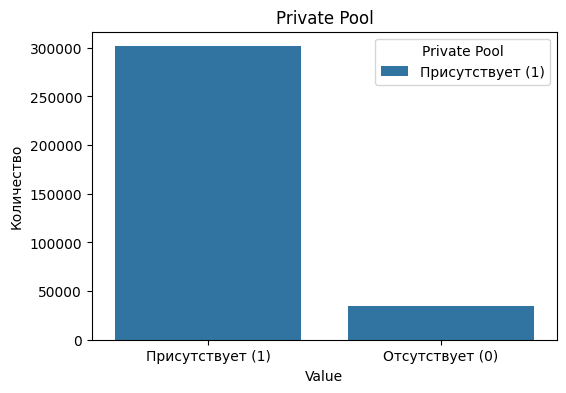

In [55]:
# Создаем график для признака Private_Pool
plt.figure(figsize=(6, 4))
sns.countplot(data=data, x='Private_Pool')
plt.title('Private Pool')
plt.xlabel('Value')
plt.ylabel('Количество')

# Заменяем подписи оси x
plt.xticks([0, 1], ['Присутствует (1)', 'Отсутствует (0)'])

# Добавляем легенду
plt.legend(title='Private Pool', labels=['Присутствует (1)', 'Отсутствует (0)'])
plt.show()

Из представленного графика следует, что наличие частного бассейна является распространённой характеристикой для большинства домовладений.  

### YearBuilt

В данном фрагменте кода для колонки 'YearBuilt', которая отражает год постройки зданий, первоначально происходит заполнение отсутствующих данных медианным годом постройки. Затем, все записи конвертируются в числовой формат, при этом значения, не являющиеся числами, заменяются на `NaN`. В последующем, все `NaN`-значения заменяются медианными, после чего колонка целиком переводится в целочисленный тип данных, что способствует стандартизации и повышению точности данных для последующего анализа. 

In [56]:
# Замена пустых значений в столбце 'YearBuilt' на медианное значение этого столбца
data['YearBuilt'].fillna(data['YearBuilt'].median(), inplace=True)

data['YearBuilt'] = data['YearBuilt'].astype(int)

# Преобразование пустых строк и других нечисловых значений в NaN
data['YearBuilt'] = pd.to_numeric(data['YearBuilt'], errors='coerce')

# Заполнение NaN медианой
data['YearBuilt'].fillna(data['YearBuilt'].median(), inplace=True)

# Преобразование данных в целочисленный тип
data['YearBuilt'] = data['YearBuilt'].astype(int)

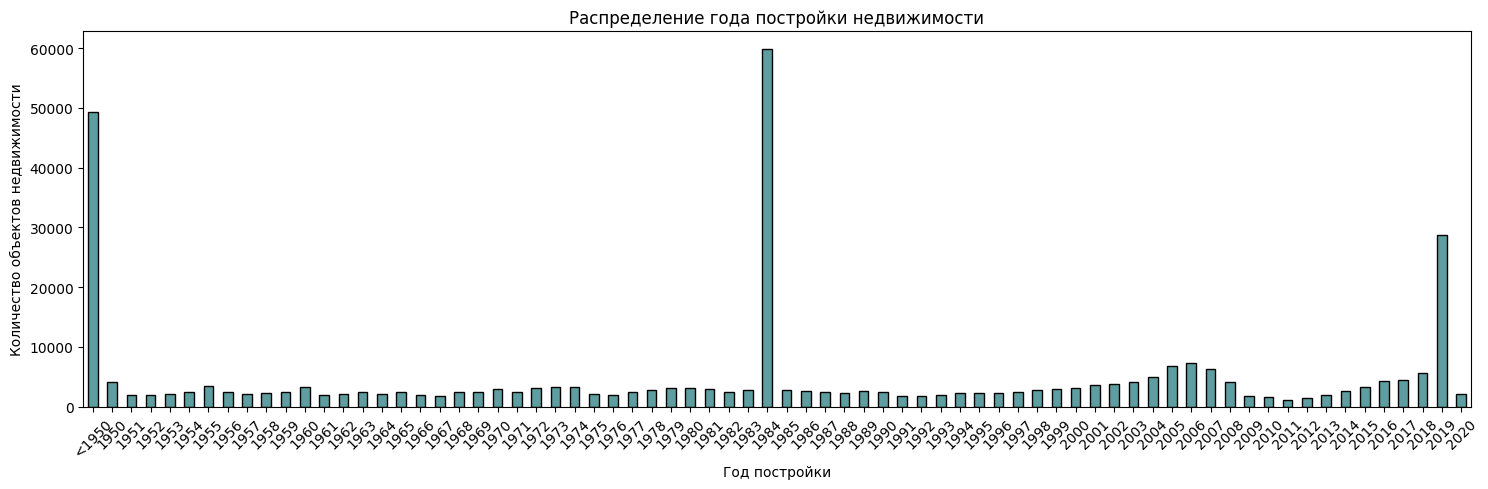

In [58]:
# Группировка данных: все до 1950 группируем в одну категорию
YearBuiltGrouped = data['YearBuilt'].apply(lambda x: '<1950' if x < 1950 else str(x))

# Получаем уникальные значения в правильном порядке
unique_years = ['<1950'] + [str(year) for year in range(1950, 2021)]
year_order = {year: order for order, year in enumerate(unique_years)}

# Сортируем годы постройки в соответствии с порядком, установленным выше
ordered_year_counts = YearBuiltGrouped.value_counts().reindex(unique_years, fill_value=0)

# Гистограмма распределения группированных годов постройки
plt.figure(figsize=(15, 5))
ordered_year_counts.plot(kind='bar', color='cadetblue', edgecolor='black')

# Настройки графика
plt.title('Распределение года постройки недвижимости')
plt.xlabel('Год постройки')
plt.ylabel('Количество объектов недвижимости')
plt.xticks(rotation=45)  # Поворот подписей на оси X для лучшей читаемости
plt.tight_layout()
plt.show()


График демонстрирует, как распределяются дома по годам постройки. Из данных видно, что пиковые периоды строительства приходятся на времена до 1950 года и после 2010 года, в то время как в промежуточный период зафиксировано меньшее количество построек. Это может быть связано с историческими изменениями в строительной отрасли и экономическими циклами, когда активное строительство совпадало с периодами экономического роста или государственными программами по стимулированию строительства. Стоит отметить, что информация о зданиях, построенных до 1950 года, представлена в виде одной категории, что может говорить о недостаточности или отсутствии данных за этот период. 

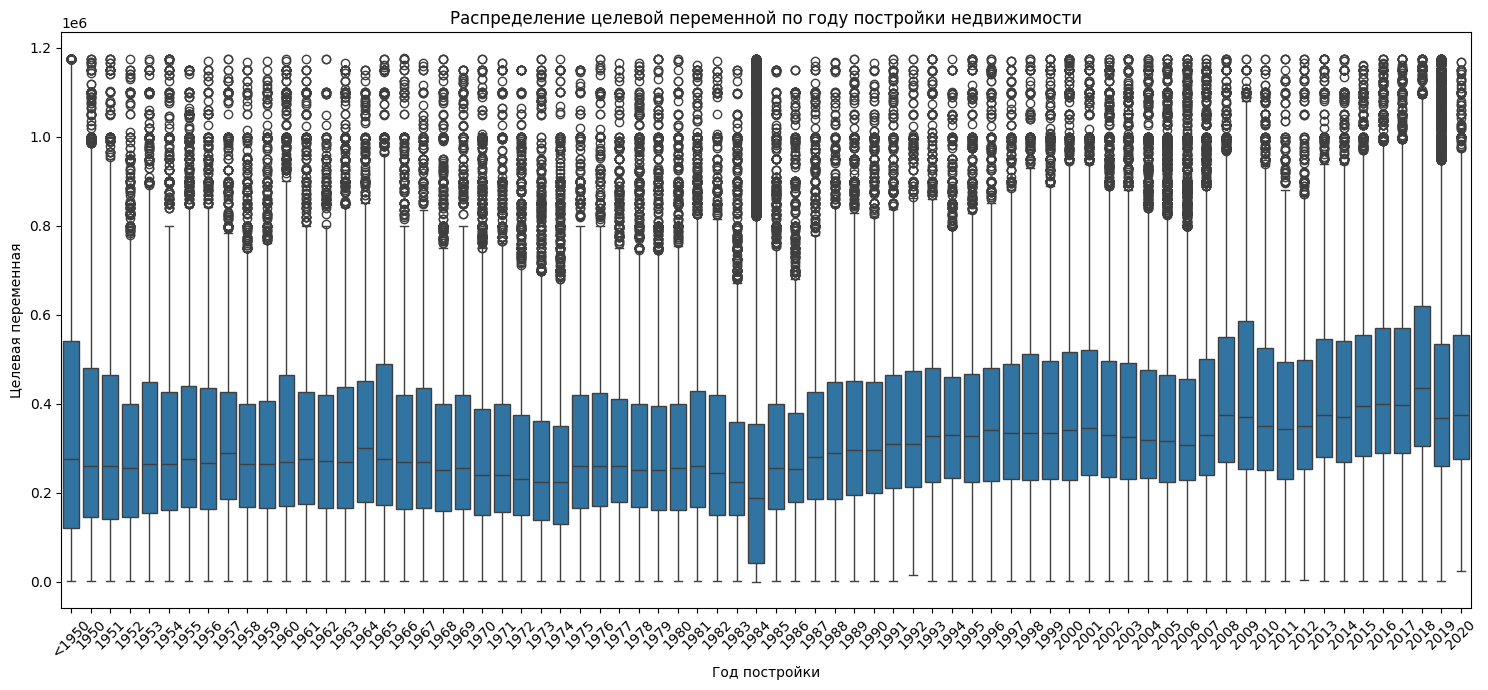

In [59]:
# Группировка данных: все до 1950 группируем в одну категорию
YearBuiltGrouped = data['YearBuilt'].apply(lambda x: '<1950' if x < 1950 else str(x))

# Получаем уникальные значения в правильном порядке
unique_years = ['<1950'] + [str(year) for year in range(1950, 2021)]

# Построение коробчатого графика
plt.figure(figsize=(15, 7))
sns.boxplot(x=YearBuiltGrouped, y=data['target'], order=unique_years)
plt.title('Распределение целевой переменной по году постройки недвижимости')
plt.xlabel('Год постройки')
plt.ylabel('Целевая переменная')
plt.xticks(rotation=45)  # Поворот подписей на оси X для лучшей читаемости
plt.tight_layout()
plt.show()


Исходя из анализа коробчатой диаграммы, можно сформулировать следующие наблюдения:

1. **Однородность цен**: Медианные значения цен (линии в середине ящиков) показывают схожесть на протяжении разных временных периодов строительства, что может указывать на то, что год возведения зданий не играет решающей роли в формировании цен на недвижимость.

2. **Аномальные значения**: Наличие множества аномалий в каждом временном сегменте свидетельствует о широком диапазоне цен, что может быть обусловлено разнообразием качества, расположения, размеров и других характеристик объектов, не учитываемых при определении года постройки.

3. **Диапазон цен**: Размеры ящиков, отображающие межквартильный размах, различаются в зависимости от периода, что может отражать изменения в рыночных условиях, экономические колебания или спрос на недвижимость в разные времена.

4. **Современная недвижимость**: Объекты, возведенные в более новые временные отрезки (конец диаграммы), обычно имеют более высокую медианную цену, особенно после 2000 года, что может отражать последние тенденции в строительстве или рост стоимости недвижимости.

5. **Историческая недвижимость**: Категория "<1950" показывает более широкий межквартильный размах и множество аномалий, что может свидетельствовать о значительном разнообразии цен на историческую недвижимость, возможно, из-за различий в состоянии сохранности и местоположении.

Для более полного понимания тенденций на рынке недвижимости требуется анализ дополнительных данных и более глубокое исследование, с учетом таких важных аспектов, как локация, площадь, состояние объекта и наличие удобств. 

### RemodeledYear

В данном фрагменте кода происходит обработка данных в колонке 'RemodeledYear', отражающей год обновления (ремонта) объекта недвижимости. Изначально, строки без указания года заменяются на значение `NaN`, что позволяет унифицировать обработку отсутствующих данных. После этого, все `NaN` преобразуются в нули, что является стандартной процедурой для заполнения пропусков в данных. В завершение, все значения колонки конвертируются в целые числа, облегчая тем самым последующий анализ и построение моделей.

In [61]:
# Преобразование пустых строк в NaN
data['RemodeledYear'] = data['RemodeledYear'].replace('', np.nan)
data['RemodeledYear'].fillna(0, inplace=True) # median_remodeled_year
data['RemodeledYear'] = data['RemodeledYear'].astype(int)

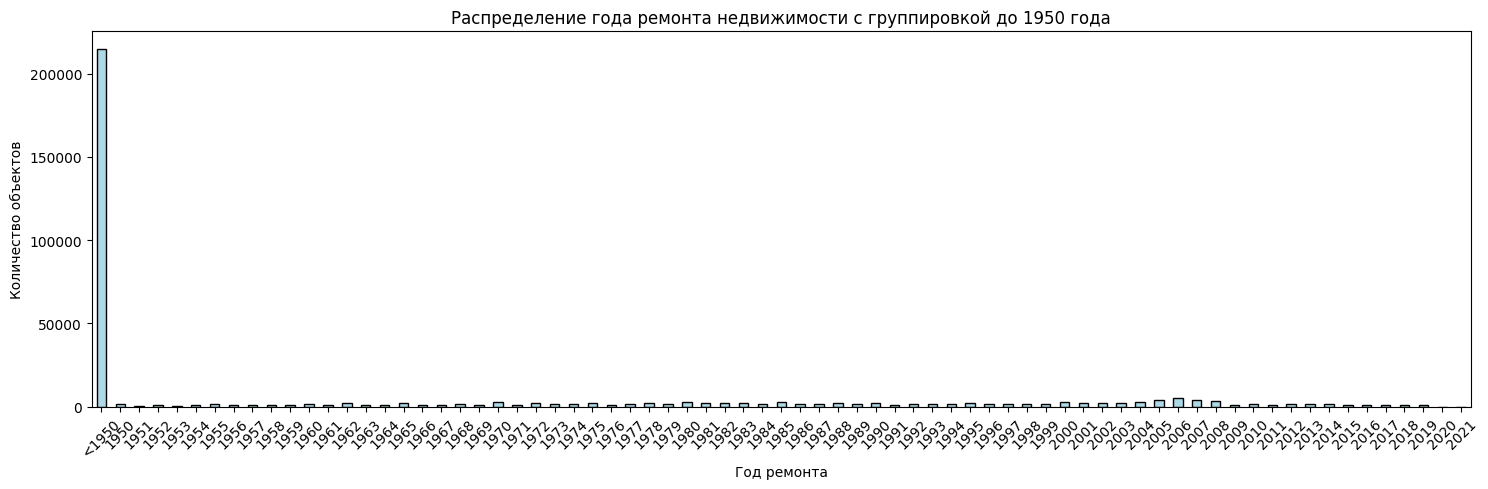

In [62]:
# Группировка значений до 1950 года в одну категорию
YearCategory = data['RemodeledYear'].apply(lambda x: '<1950' if x < 1950 else str(x))

# Получение упорядоченных уникальных значений
ordered_years = ['<1950'] + [str(year) for year in range(1950, data['RemodeledYear'].max() + 1)]

# Подсчет количества для каждой категории с учетом порядка
grouped_values = YearCategory.value_counts().reindex(ordered_years, fill_value=0)

# Отображение гистограммы с группировкой
plt.figure(figsize=(15, 5))
grouped_values.plot(kind='bar', color='lightblue', edgecolor='black')

# Настройка графика
plt.title('Распределение года ремонта недвижимости с группировкой до 1950 года')
plt.xlabel('Год ремонта')
plt.ylabel('Количество объектов')
plt.xticks(rotation=45)  # Поворот подписей для лучшей читаемости
plt.tight_layout()
plt.show()


Из графика следует, что большинство значений приходится на период до 1950 года, в то время как данные после этого года распределены более равномерно. 

### LotSize

В приведенном коде происходит обработка колонки 'LotSize', отражающей площадь земельных участков. Сначала все значения приводятся к текстовому формату, после чего из них удаляются запятые и пробелы для унификации данных. Затем осуществляется перевод в числовой тип данных (`float`), при этом ошибочные значения заменяются на `NaN`. После этого рассчитывается медиана для 'LotSize', которая применяется для заполнения пропущенных данных, что позволяет сохранить представительность данных для анализа. 

In [63]:
# Преобразование в строковый тип
data['LotSize'] = data['LotSize'].astype(str)

# Удаление запятых и пробелов
data['LotSize'] = data['LotSize'].str.replace(',', '').str.replace(' ', '')

# Преобразование в числовой тип (float)
data['LotSize'] = pd.to_numeric(data['LotSize'], errors='coerce')

# Находим медиану признака "LotSize"
median_LotSize = data['LotSize'].median()
# Замена пустых значений на моду
data['LotSize'].fillna(median_LotSize, inplace=True)

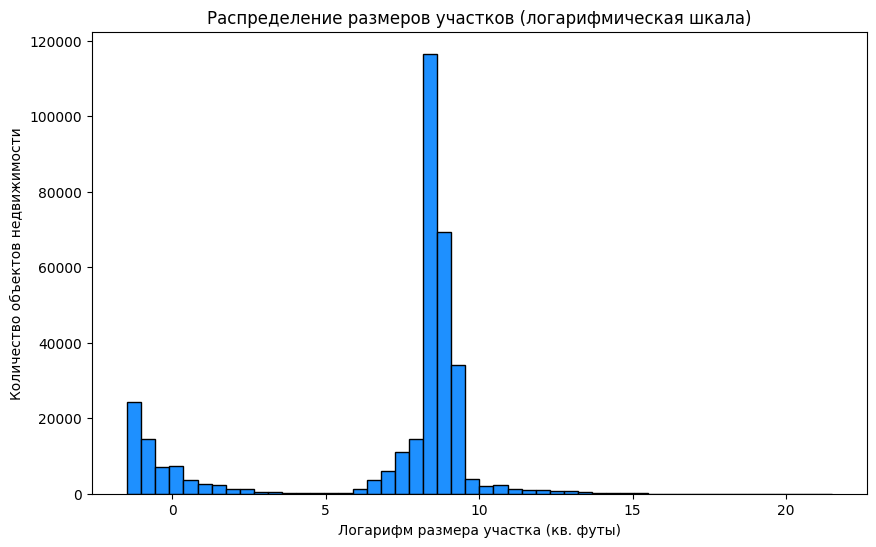

In [64]:
# Чтобы избежать искажения распределения из-за очень больших или маленьких значений,
# мы можем применить логарифмическое преобразование к значениям 'LotSize'

# Удаляем нулевые и отрицательные значения, так как логарифм от них не берется
positive_lot_sizes = data['LotSize'][data['LotSize'] > 0]

# Применяем логарифмическое преобразование
log_lot_sizes = np.log(positive_lot_sizes)

# Строим гистограмму
plt.figure(figsize=(10, 6))
plt.hist(log_lot_sizes, bins=50, color='dodgerblue', edgecolor='black')

# Настраиваем отображение графика
plt.title('Распределение размеров участков (логарифмическая шкала)')
plt.xlabel('Логарифм размера участка (кв. футы)')
plt.ylabel('Количество объектов недвижимости')
plt.show()


График демонстрирует распределение площадей участков в логарифмической шкале. Заметна тенденция к меньшим размерам участков, поскольку основные пики графика располагаются у начальной части оси X. Это свидетельствует о явном смещении распределения в сторону меньших значений, с преобладанием участков меньшего размера в общем объеме данных. 

### PricePerSqft

В представленном коде осуществляется трансформация данных в колонке 'PricePerSqft', отражающей цену за квадратный фут недвижимости. Все записи сначала конвертируются в строки, после чего происходит извлечение числовых значений. Обнаруженные числа приводятся к типу данных `float`, а некорректные значения заменяются на `NaN`. Затем определяется модальное значение столбца, которое используется для заполнения отсутствующих данных. В случае отсутствия выраженной моды применяется значение `np.nan`. Такой подход позволяет корректно восстановить недостающие данные для дальнейшего анализа. 

In [65]:
# Преобразование в формат строки
data['PricePerSqft'] = data['PricePerSqft'].astype(str)
# Извлечение числовых значений
data['PricePerSqft'] = data['PricePerSqft'].apply(lambda x: re.findall(r'\d+', x))
data['PricePerSqft'] = data['PricePerSqft'].apply(lambda x: float(x[0]) if x else np.nan)

# Вычисление моды с учетом возможности нескольких модальных значений
mode_PricePerSqft = data['PricePerSqft'].mode()
if len(mode_PricePerSqft) > 0:
    mode_PricePerSqft = mode_PricePerSqft[0]
else:
    mode_PricePerSqft = np.nan  # Если нет моды, можно использовать np.nan или другое значение по умолчанию

# Замена пустых значений на моду
data['PricePerSqft'].fillna(mode_PricePerSqft, inplace=True)

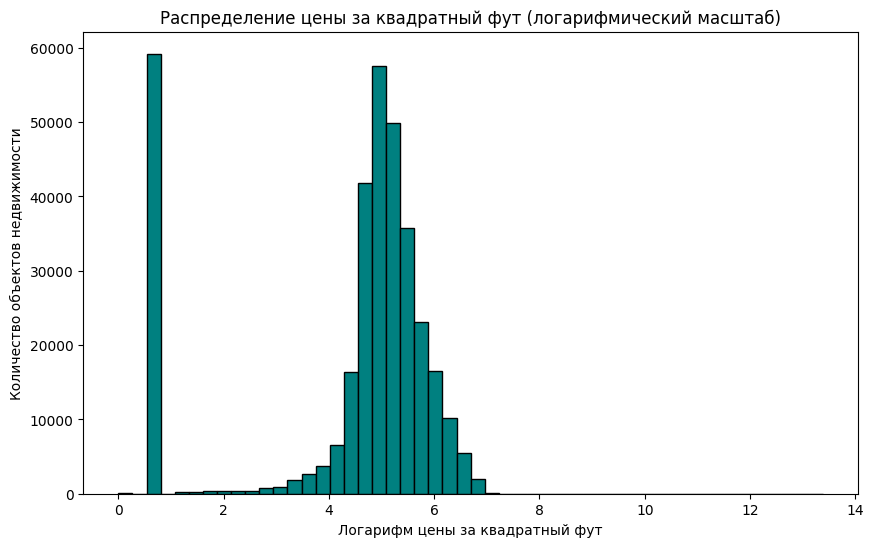

In [66]:
# Преобразование данных в логарифмический масштаб, если распределение слишком широкое
PricePerSqft_log = np.log1p(data['PricePerSqft'])

plt.figure(figsize=(10, 6))
plt.hist(PricePerSqft_log, bins=50, color='teal', edgecolor='black')
plt.title('Распределение цены за квадратный фут (логарифмический масштаб)')
plt.xlabel('Логарифм цены за квадратный фут')
plt.ylabel('Количество объектов недвижимости')
plt.show()

Гистограмма иллюстрирует распределение стоимости недвижимости за квадратный фут, представленное в логарифмическом измерении. Основная масса данных сосредоточена у начала оси X, что говорит о преобладании объектов с более низкой ценой за квадратный фут. Наибольшая частота значений цены за квадратный фут наблюдается в нижнем сегменте логарифмической шкалы, что отражает высокую плотность объектов с схожей стоимостью.

Данные распределения обладают продолжительным правым хвостом, простирающимся к более высоким значениям логарифма цены, что свидетельствует о наличии отдельных объектов с высокой стоимостью за квадратный фут, встречающихся гораздо реже, чем объекты с низкой стоимостью. 

### Avr_distance

In [67]:
# Преобразование в числовой тип (float)
data['Avr_distance'] = pd.to_numeric(data['Avr_distance'], errors='coerce')

# Вычисление медианы
median_avr_distance = data['Avr_distance'].median()

# Замена пустых значений на медиану
data['Avr_distance'].fillna(median_avr_distance, inplace=True)

In [68]:
data['Avr_distance'].describe()

count    336506.000000
mean          2.790447
std           5.722226
min           0.020000
25%           1.040000
50%           1.766667
75%           3.220000
max        1590.830000
Name: Avr_distance, dtype: float64

### MinDistance

In [69]:
# Преобразование в числовой тип (float)
data['MinDistance'] = pd.to_numeric(data['MinDistance'], errors='coerce')

# Вычисление медианы
median_MinDistance = data['MinDistance'].median()

# Замена пустых значений на медиану
data['MinDistance'].fillna(median_MinDistance, inplace=True)

### AverageRating

In [70]:
# Преобразование в числовой тип (float)
data['AverageRating'] = pd.to_numeric(data['AverageRating'], errors='coerce')

# Вычисление медианы
median_AverageRating = data['AverageRating'].median()

# Замена пустых значений на медиану
data['AverageRating'].fillna(median_AverageRating, inplace=True)

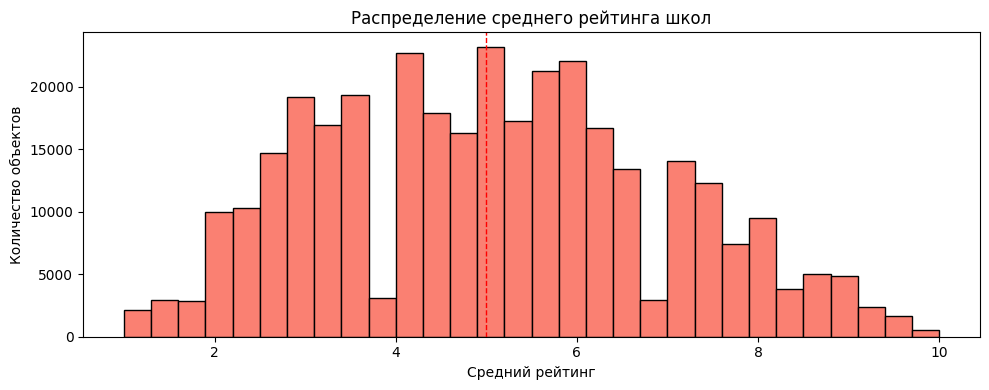

In [71]:
# Настройка параметров отображения
plt.figure(figsize=(10, 4))

# Гистограмма для признака 'AverageRating'
plt.hist(data['AverageRating'].dropna(), bins=30, color='salmon', edgecolor='black')
plt.axvline(data['AverageRating'].median(), color='red', linestyle='dashed', linewidth=1)
plt.title('Распределение среднего рейтинга школ')
plt.xlabel('Средний рейтинг')
plt.ylabel('Количество объектов')

# Показать графики
plt.tight_layout()
plt.show()

На графике отображается распределение среднего уровня рейтинга школ, связанного с объектами недвижимости. Медианное значение, отмеченное пунктирной линией, делит набор данных пополам, указывая, что у одной половины объектов рейтинг школ выше, а у другой — ниже. Основная часть объектов сгруппирована около медианных показателей рейтинга. 

### Кодировка

В последующем разделе кода осуществляется применение методов кодирования для трансформации категориальных переменных в числовой формат, что облегчает процесс анализа данных и построения моделей. Категориальные переменные, такие как 'city', 'street', 'state', 'status2' и 'propertyType_New', конвертируются в числовые индексы с использованием метода LabelEncoder. Для переменных 'mlsID' и 'fireplace' задействуются особые правила: 'mlsID' преобразуется в двоичный формат, где '1' указывает на присутствие значения, а '0' — на его отсутствие; в случае 'fireplace' применяется метод подстановки, при котором '1' означает несуществование камина, а '0' — его присутствие. 

#### city

In [72]:
label_encoder = LabelEncoder()
data['city'] = label_encoder.fit_transform(data['city'])

data['city'].head()

0    1643
1    1653
4    1291
5    1332
6    1283
Name: city, dtype: int32

#### MlsId

In [73]:
# Заменяем все непустые значения на 1, остальные на 1
data['mlsID'] = data['mlsID'].apply(lambda x: 1 if pd.notnull(x) else 0)

#### fireplace

In [74]:
# Создадим словарь для замены значений, где 1 - отстутствует, 0-присутствует
replace_func = lambda x: '1' if x in ['', 'No', 'No Fireplace', 'None', 'Not Applicable'] else '0'

# применим lambda функцию
data['fireplace'] = data['fireplace'].map(replace_func).astype(float)
data['fireplace'] = data['fireplace'].astype(int)

data['fireplace'].value_counts()

fireplace
0    334225
1      2281
Name: count, dtype: int64

#### street, state, status2, propertyType_New

In [75]:
label_encoder = LabelEncoder()
data['street'] = label_encoder.fit_transform(data['street'])
data['state'] = label_encoder.fit_transform(data['state'])
data['status2'] = label_encoder.fit_transform(data['status2'])
data['propertyType_New'] = label_encoder.fit_transform(data['propertyType_New'])

In [76]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 336506 entries, 0 to 377184
Data columns (total 26 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   street            336506 non-null  int32  
 1   baths             336506 non-null  int32  
 2   fireplace         336506 non-null  int32  
 3   city              336506 non-null  int32  
 4   sqft              336506 non-null  float64
 5   zipcode           336506 non-null  int64  
 6   state             336506 non-null  int32  
 7   stories           336506 non-null  float64
 8   target            336506 non-null  float64
 9   status2           336506 non-null  int32  
 10  propertyType_New  336506 non-null  int32  
 11  state_full        336506 non-null  object 
 12  YearBuilt         336506 non-null  int32  
 13  RemodeledYear     336506 non-null  int32  
 14  Heating           336506 non-null  int32  
 15  Cooling           336506 non-null  int32  
 16  Parking           336506 

## 4.Создание модели

#### Подготовка данных

Процесс анализа данных начинается с оценки корреляции между переменными и построения тепловой карты, чтобы наглядно представить корреляционную матрицу. После того как корреляция между переменными и целевой переменной 'target' рассчитана, мы отбираем те признаки, которые имеют корреляцию выше 0.7. Для удобства анализа взаимосвязей между переменными создается тепловая карта корреляций. Из-за низкой корреляции или избыточности удаляется переменная 'Avr_distance'. Затем, для использования в линейной регрессии, целевая переменная 'target' подвергается логарифмированию, а все остальные признаки стандартизируются и разделяются на тренировочную и тестовую выборки для дальнейшего анализа. 

In [77]:
data = data.drop(['state_full'], axis=1) # удаляем 
corr = data.corr()     #построим корреляционную матрицу

new_corr = corr['target'].reset_index()
sort_corr = new_corr.sort_values('target', ascending=False)
sort_corr.head(10)

correlation_matrix = data.corr()

high_correlation = correlation_matrix[abs(correlation_matrix) > 0.7].stack().reset_index()
high_correlation = high_correlation[high_correlation['level_0'] != high_correlation['level_1']]
print(high_correlation)

         level_0       level_1         0
20  Avr_distance   MinDistance  0.908224
21   MinDistance  Avr_distance  0.908224


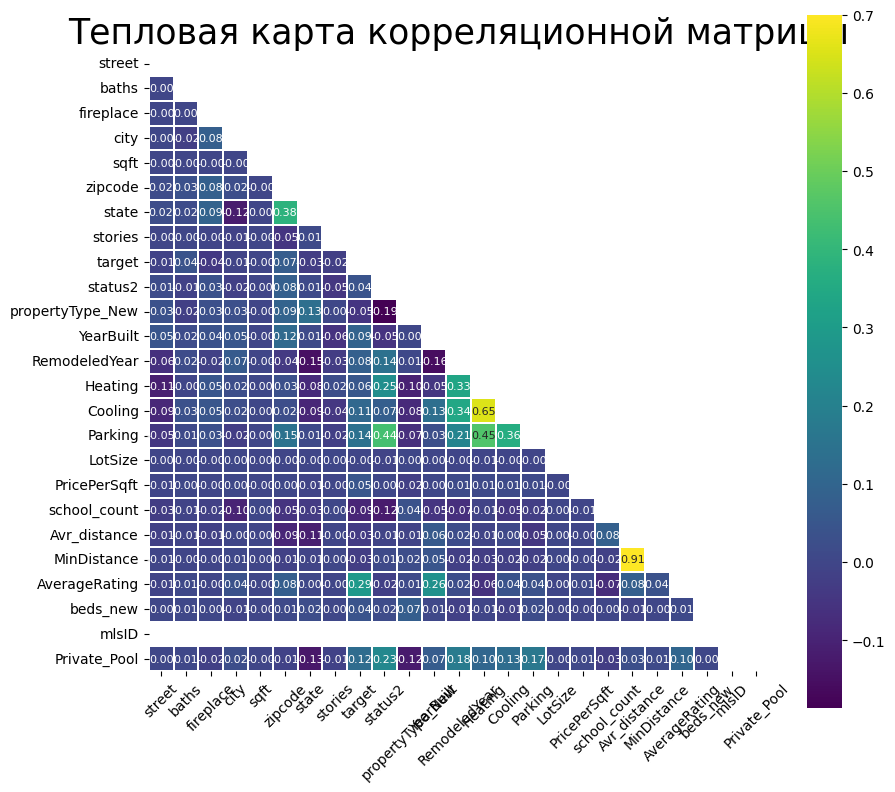

In [78]:
# Создаем маску для отображения только нижней половины матрицы
mask = np.zeros_like(correlation_matrix, dtype=bool)
mask[np.triu_indices_from(mask)] = True

# Создание тепловой карты с указанными размерами фигуры
plt.figure(figsize=(10, 10))

# Создадим тепловую карту с маской и указанными стилями
ax = sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="viridis", linewidths=0.25, vmax=0.7,
                 mask=mask, square=True, cbar_kws={"shrink": .9}, annot_kws={"size":8})

# Установим заголовок с размером шрифта 25
plt.title('Тепловая карта корреляционной матрицы', fontsize=25)

# Получаем текущие подписи оси X и устанавливаем желаемый наклон
xticklabels = ax.get_xticklabels()
ax.set_xticklabels(xticklabels, rotation=45)

# Получаем текущие подписи оси Y и устанавливаем желаемый наклон
yticklabels = ax.get_yticklabels()
ax.set_yticklabels(yticklabels, rotation=0)

# Показываем график
plt.show()

Анализ представленной корреляционной тепловой карты позволяет сделать ряд выводов:

1. **Связь между системами отопления и охлаждения**: Присутствует выраженная положительная корреляция (0.65) между системами отопления и охлаждения, что может свидетельствовать о тенденции оснащения объектов современными системами отопления и охлаждения одновременно.

2. **Взаимосвязь года ремонта и года постройки**: Между годом последнего ремонта (RemodeledYear) и годом постройки (YearBuilt) наблюдается умеренная отрицательная корреляция (-0.06), что может указывать на более частые обновления или модернизацию старых зданий.

3. **Зависимость цены от близости к удобствам**: Наличие сильной положительной корреляции (0.91) между ценой и минимальным расстоянием до удобств (MinDistance) подтверждает, что расположение недвижимости в непосредственной близости к сервисам и удобствам существенно увеличивает её стоимость.

4. **Признаки с низкой корреляцией**: Множество переменных демонстрируют корреляцию, стремящуюся к нулю с целевой переменной, что говорит о их ограниченном влиянии на стоимость недвижимости в линейной зависимости. 

In [79]:
# удалим лишний признак с высокой корреляцией
data = data.drop(['Avr_distance'], axis=1)

data['target_log'] = np.log(data['target']+1)

X = data.drop(['target', 'Cooling','Parking', 'target_log'], axis=1)
y = data['target_log']

scale = StandardScaler()
X_scaled = scale.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

#### Тестирование моделей

Выполним обучение и оценку шести различных регрессионных моделей:

In [80]:
# 1. Regression Linier
linear_reg = LinearRegression()
linear_reg.fit(X_train, y_train)
y_pred_linear = linear_reg.predict(X_test)
mse_linear = mean_squared_error(y_test, y_pred_linear)

In [81]:
# 2. Ridge Regression
ridge_reg = Ridge()
ridge_reg.fit(X_train, y_train)
y_pred_ridge = ridge_reg.predict(X_test)
mse_ridge = mean_squared_error(y_test, y_pred_ridge)

In [82]:
# 3. Lasso Regression
lasso_reg = Lasso()
lasso_reg.fit(X_train, y_train)
y_pred_lasso = lasso_reg.predict(X_test)
mse_lasso = mean_squared_error(y_test, y_pred_lasso)

In [83]:
# 4. Decision Tree Regression
decision_tree_reg = DecisionTreeRegressor()
decision_tree_reg.fit(X_train, y_train)
y_pred_tree = decision_tree_reg.predict(X_test)
mse_tree = mean_squared_error(y_test, y_pred_tree)

In [104]:
# 5. Random Forest Regression
random_forest_reg = RandomForestRegressor()
random_forest_reg.fit(X_train, y_train)
y_pred_forest = random_forest_reg.predict(X_test)
mse_forest = mean_squared_error(y_test, y_pred_forest)


In [85]:
# 6. XGBRegressor
xgb_reg = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
xgb_reg.fit(X_train, y_train)
y_pred_xgb = xgb_reg.predict(X_test)
mse_xgb = mean_squared_error(y_test, y_pred_xgb)

Запишем показатели качества моделей (MSE и R-squared) в таблицу данных results_df3 для последующего сопоставления эффективности разных моделей регрессии. 

In [105]:
results_df3 = pd.DataFrame(index=['Linear Regression', 'Ridge Regression', 'Lasso Regression', 'Decision Tree', 'Random Forest', 'XGBRegressor'])

results_df3['Mean Squared Error'] = [
    mse_linear,
    mse_ridge,
    mse_lasso,
    mse_tree,
    mse_forest,
    mse_xgb
]

results_df3['R-squared'] = [
    r2_score(y_test, y_pred_linear),
    r2_score(y_test, y_pred_ridge),
    r2_score(y_test, y_pred_lasso),
    r2_score(y_test, y_pred_tree),
    r2_score(y_test, y_pred_forest),
    r2_score(y_test, y_pred_xgb)
]

print(results_df3)

                   Mean Squared Error  R-squared
Linear Regression            0.865897   0.170569
Ridge Regression             0.865897   0.170569
Lasso Regression             1.043980  -0.000015
Decision Tree                0.163695   0.843198
Random Forest                0.085059   0.918523
XGBRegressor                 0.106124   0.898346


Заключение: Ввиду ограниченности ресурсов и необходимости в скорости обучения и предсказания, XGBoost является оптимальным вариантом, так как он справляется с задачей менее чем за одну секунду. Тем не менее, если приоритет отдается точности предсказаний и возможно расходование большего количества ресурсов, то выбор может пасть на Random Forest, который выполняет задачу за две минуты. 
Для дальнейшей реализации выбрана Random Forest

#### Построение моделей Random Forest с разными гиперпараметрами 

Мы будем заниматься подбором следующих гиперпараметров:
* n_estimators — число «деревьев» в «случайном лесу».
* max_features — число признаков для выбора расщепления.
* max_depth — максимальная глубина деревьев.
* min_samples_split — минимальное число объектов, необходимое для того, чтобы узел дерева мог бы расщепиться.
* min_samples_leaf — минимальное число объектов в листьях.
* bootstrap — использование для построения деревьев подвыборки с возвращением.

In [107]:
# Проводим глобальный поиск гиперпараметров для модели
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)]
max_features = ['log2', 'sqrt']
max_depth = [int(x) for x in np.linspace(start = 1, stop = 15, num = 15)]
min_samples_split = [int(x) for x in np.linspace(start = 2, stop = 50, num = 10)]
min_samples_leaf = [int(x) for x in np.linspace(start = 2, stop = 50, num = 10)]
bootstrap = [True, False]
param_dist = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
rs = RandomizedSearchCV(random_forest_reg, 
                        param_dist, 
                        n_iter = 100, 
                        cv = 3, 
                        verbose = 1, 
                        n_jobs=-1, 
                        random_state=0)
rs.fit(X_train, y_train)
rs.best_params_

Fitting 3 folds for each of 100 candidates, totalling 300 fits


{'n_estimators': 600,
 'min_samples_split': 23,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_depth': 15,
 'bootstrap': False}

In [108]:
'''
Для того чтобы выяснить то, в каком диапазоне значений стоит продолжать поиск, 
мы легко можем получить датафрейм, содержащий результаты работы алгоритма RandomizedSearchCV
'''
rs_df = pd.DataFrame(rs.cv_results_).sort_values('rank_test_score').reset_index(drop=True)
rs_df = rs_df.drop([
            'mean_fit_time', 
            'std_fit_time', 
            'mean_score_time',
            'std_score_time', 
            'params', 
            'split0_test_score', 
            'split1_test_score', 
            'split2_test_score', 
            'std_test_score'],
            axis=1)
rs_df.head(10)

,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_features,param_max_depth,param_bootstrap,mean_test_score,rank_test_score
0,600,23,2,sqrt,15,False,0.836291,1
1,700,23,7,log2,15,False,0.832955,2
2,400,23,2,sqrt,14,False,0.825615,3
3,100,2,18,sqrt,15,False,0.823931,4
4,800,28,12,sqrt,14,True,0.815586,5
5,700,12,2,sqrt,13,False,0.814921,6
6,300,2,23,log2,14,False,0.814655,7
7,600,50,23,sqrt,14,False,0.813273,8
8,100,50,39,sqrt,15,False,0.811975,9
9,900,2,34,log2,14,False,0.808480,10


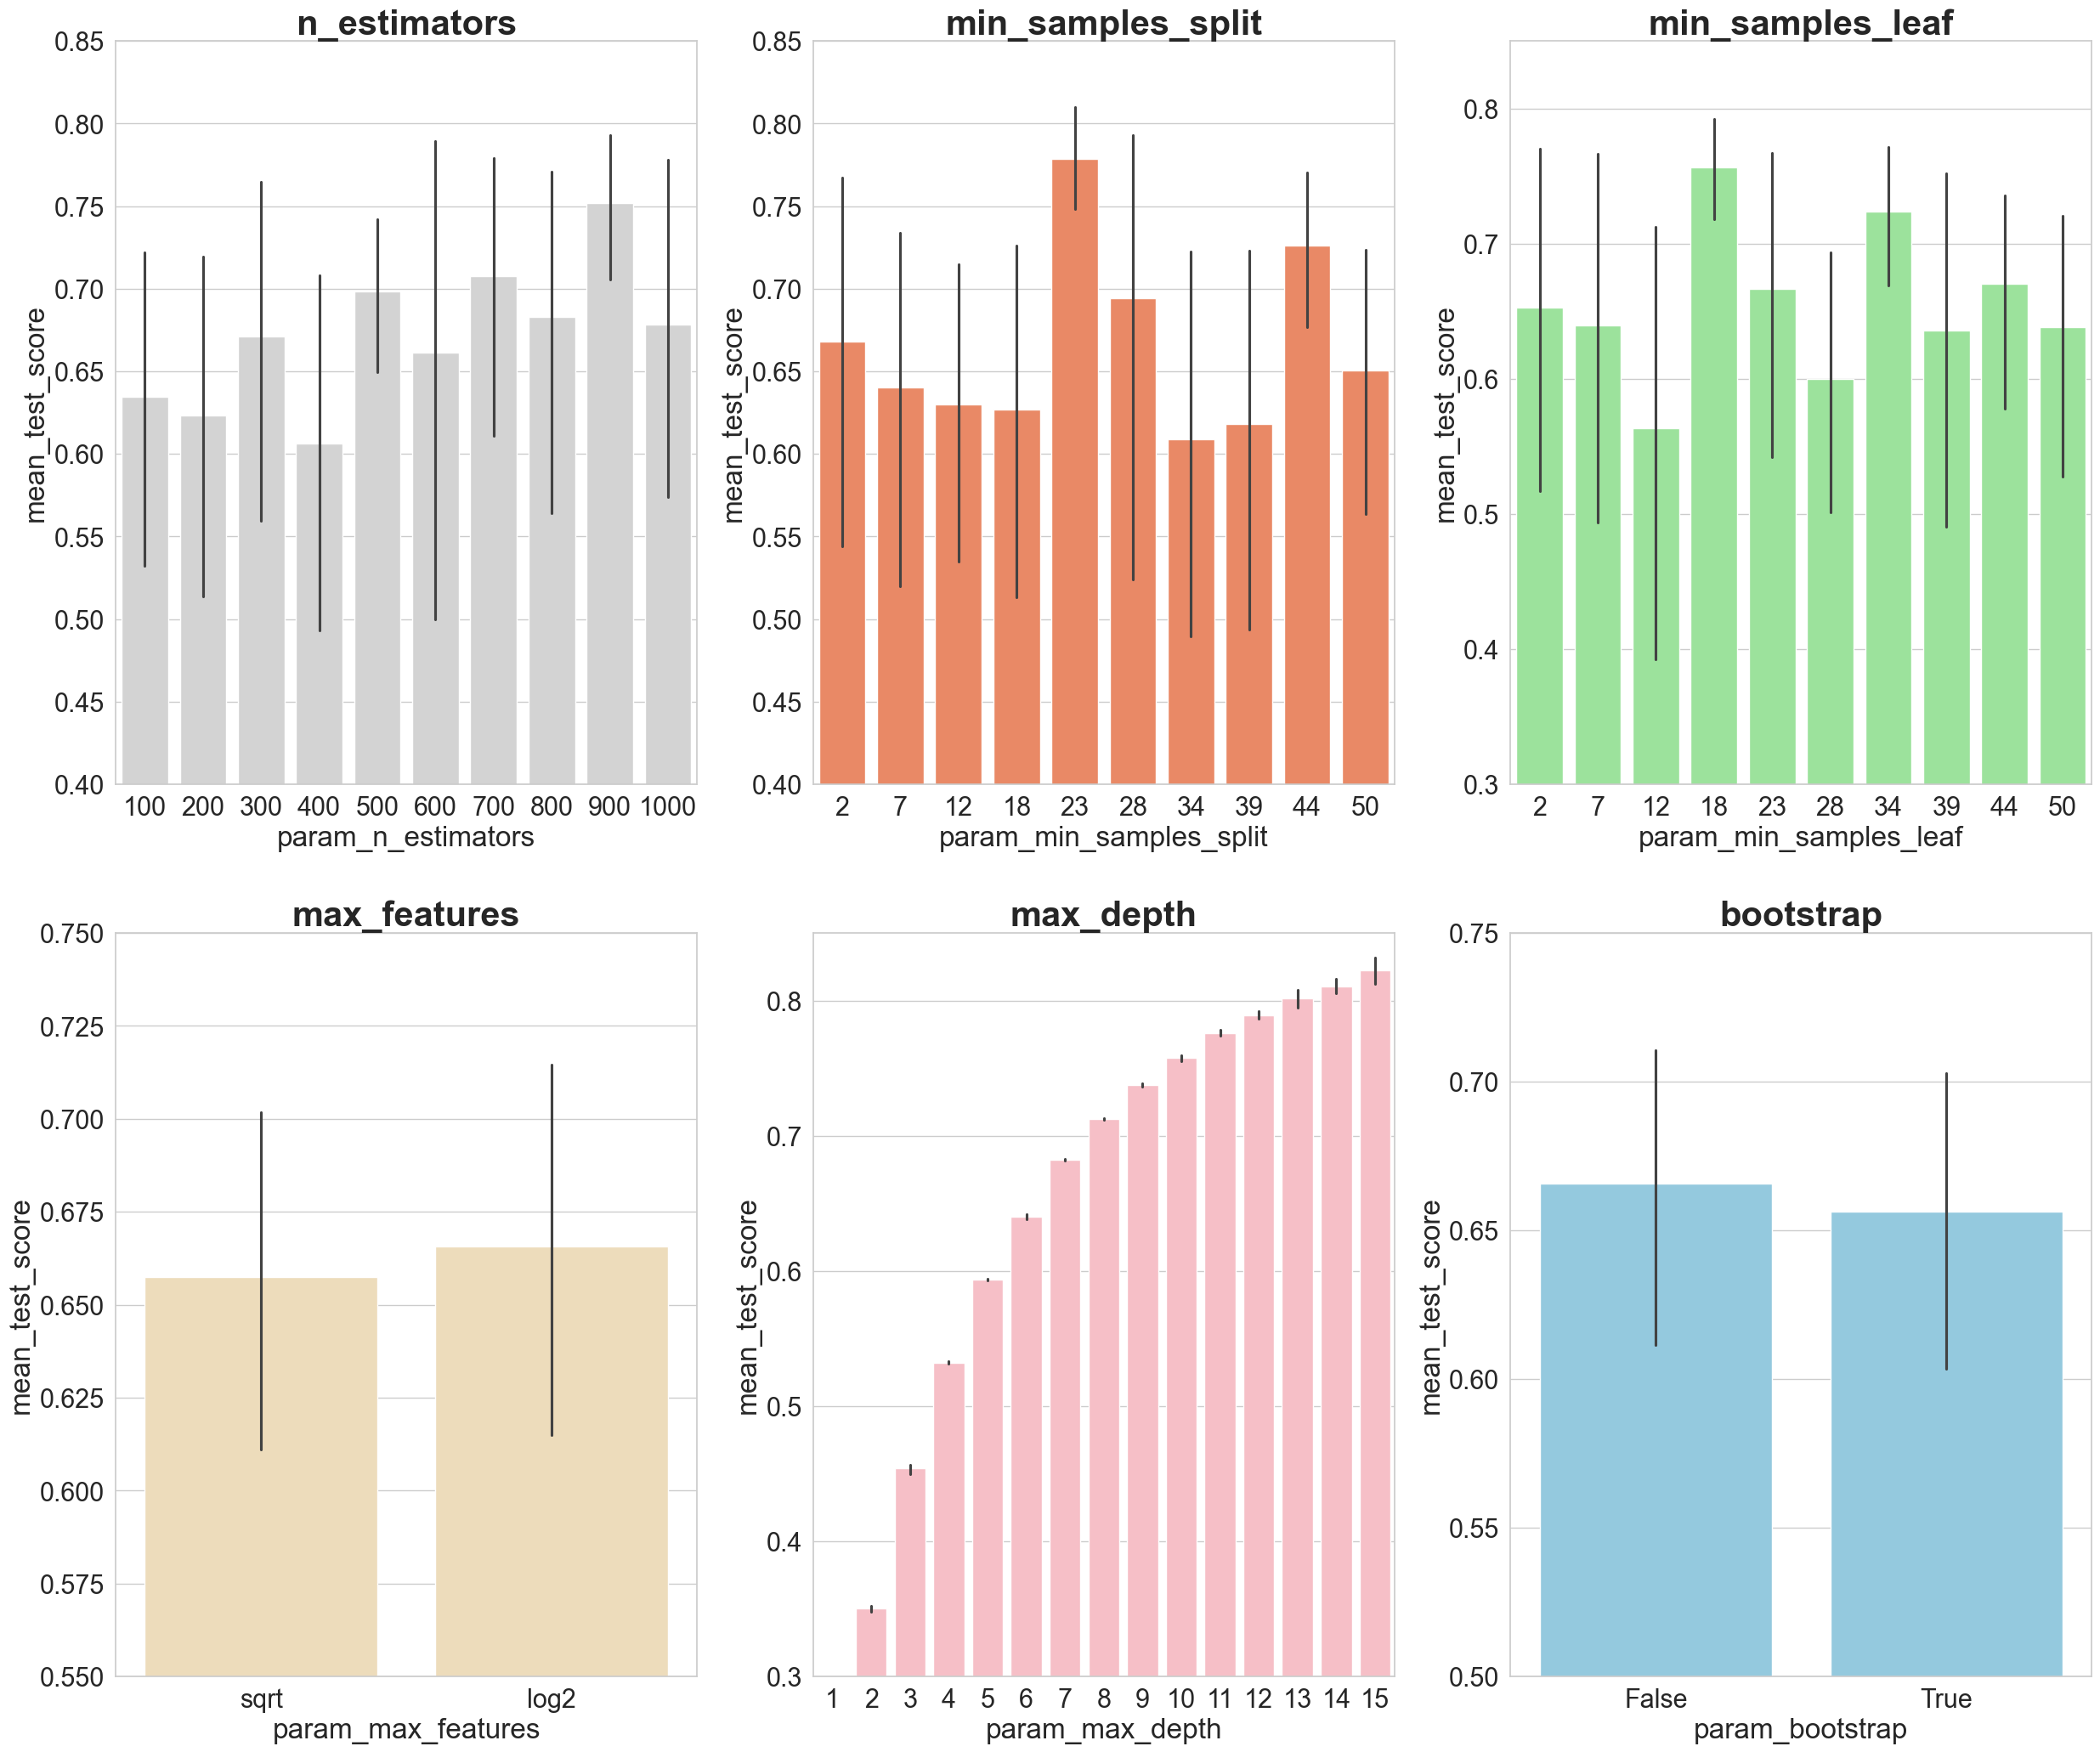

In [119]:
'''Теперь создадим столбчатые графики, на которых, по оси Х, расположены значения гиперпараметров, 
а по оси Y — средние значения, показываемые моделями. Это позволит понять то, какие значения гиперпараметров,
в среднем, лучше всего себя показывают.
'''
fig, axs = plt.subplots(ncols=3, nrows=2)
sns.set_theme(style="whitegrid", color_codes=True, font_scale = 2)
fig.set_size_inches(30,25)
sns.barplot(x='param_n_estimators', y='mean_test_score', data=rs_df, ax=axs[0,0], color='lightgrey')
axs[0,0].set_ylim([.40,.85])
axs[0,0].set_title(label = 'n_estimators', size=30, weight='bold')
sns.barplot(x='param_min_samples_split', y='mean_test_score', data=rs_df, ax=axs[0,1], color='coral')
axs[0,1].set_ylim([.40,.85])
axs[0,1].set_title(label = 'min_samples_split', size=30, weight='bold')
sns.barplot(x='param_min_samples_leaf', y='mean_test_score', data=rs_df, ax=axs[0,2], color='lightgreen')
axs[0,2].set_ylim([.30,.85])
axs[0,2].set_title(label = 'min_samples_leaf', size=30, weight='bold')
sns.barplot(x='param_max_features', y='mean_test_score', data=rs_df, ax=axs[1,0], color='wheat')
axs[1,0].set_ylim([.55,.75])
axs[1,0].set_title(label = 'max_features', size=30, weight='bold')
sns.barplot(x='param_max_depth', y='mean_test_score', data=rs_df, ax=axs[1,1], color='lightpink')
axs[1,1].set_ylim([.30,.85])
axs[1,1].set_title(label = 'max_depth', size=30, weight='bold')
sns.barplot(x='param_bootstrap',y='mean_test_score', data=rs_df, ax=axs[1,2], color='skyblue')
axs[1,2].set_ylim([.50,.75])
axs[1,2].set_title(label = 'bootstrap', size=30, weight='bold')

plt.show()

Если проанализировать вышеприведённые графики, то можно заметить некоторые интересные вещи, говорящие о том, как, в среднем, каждое значение гиперпараметра влияет на модель.

* n_estimators: значения 500, 700, 900 видимо, показывают наилучшие средние результаты.
* min_samples_split: значения 23/28 и 44 
* min_samples_leaf: 18 и 34.
* max_features: вариант log2 даёт самый высокий средний результат.
* max_depth: есть чёткая зависимость между значением гиперпараметра и результатом работы модели.
* bootstrap: значение False показывает наилучший средний результат.

Теперь мы, воспользовавшись этими находками, можем перейти ко второму раунду оптимизации гиперпараметров. Это позволит сузить спектр интересующих нас значений

In [120]:
n_estimators = [500,700, 900]
max_features = ['log2']
max_depth = [15, 20, 25, 30]
min_samples_split = [23, 28, 44]
min_samples_leaf = [18, 34]
bootstrap = [False]
param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
gs = GridSearchCV(random_forest_reg, param_grid, cv = 3, verbose = 1, n_jobs=-1)
gs.fit(X_train, y_train)
rfc_3 = gs.best_estimator_
gs.best_params_

Fitting 3 folds for each of 72 candidates, totalling 216 fits


{'bootstrap': False,
 'max_depth': 30,
 'max_features': 'log2',
 'min_samples_leaf': 18,
 'min_samples_split': 23,
 'n_estimators': 500}

Если нам интересно узнать о том, какие признаки являются самыми важными для RF-модели

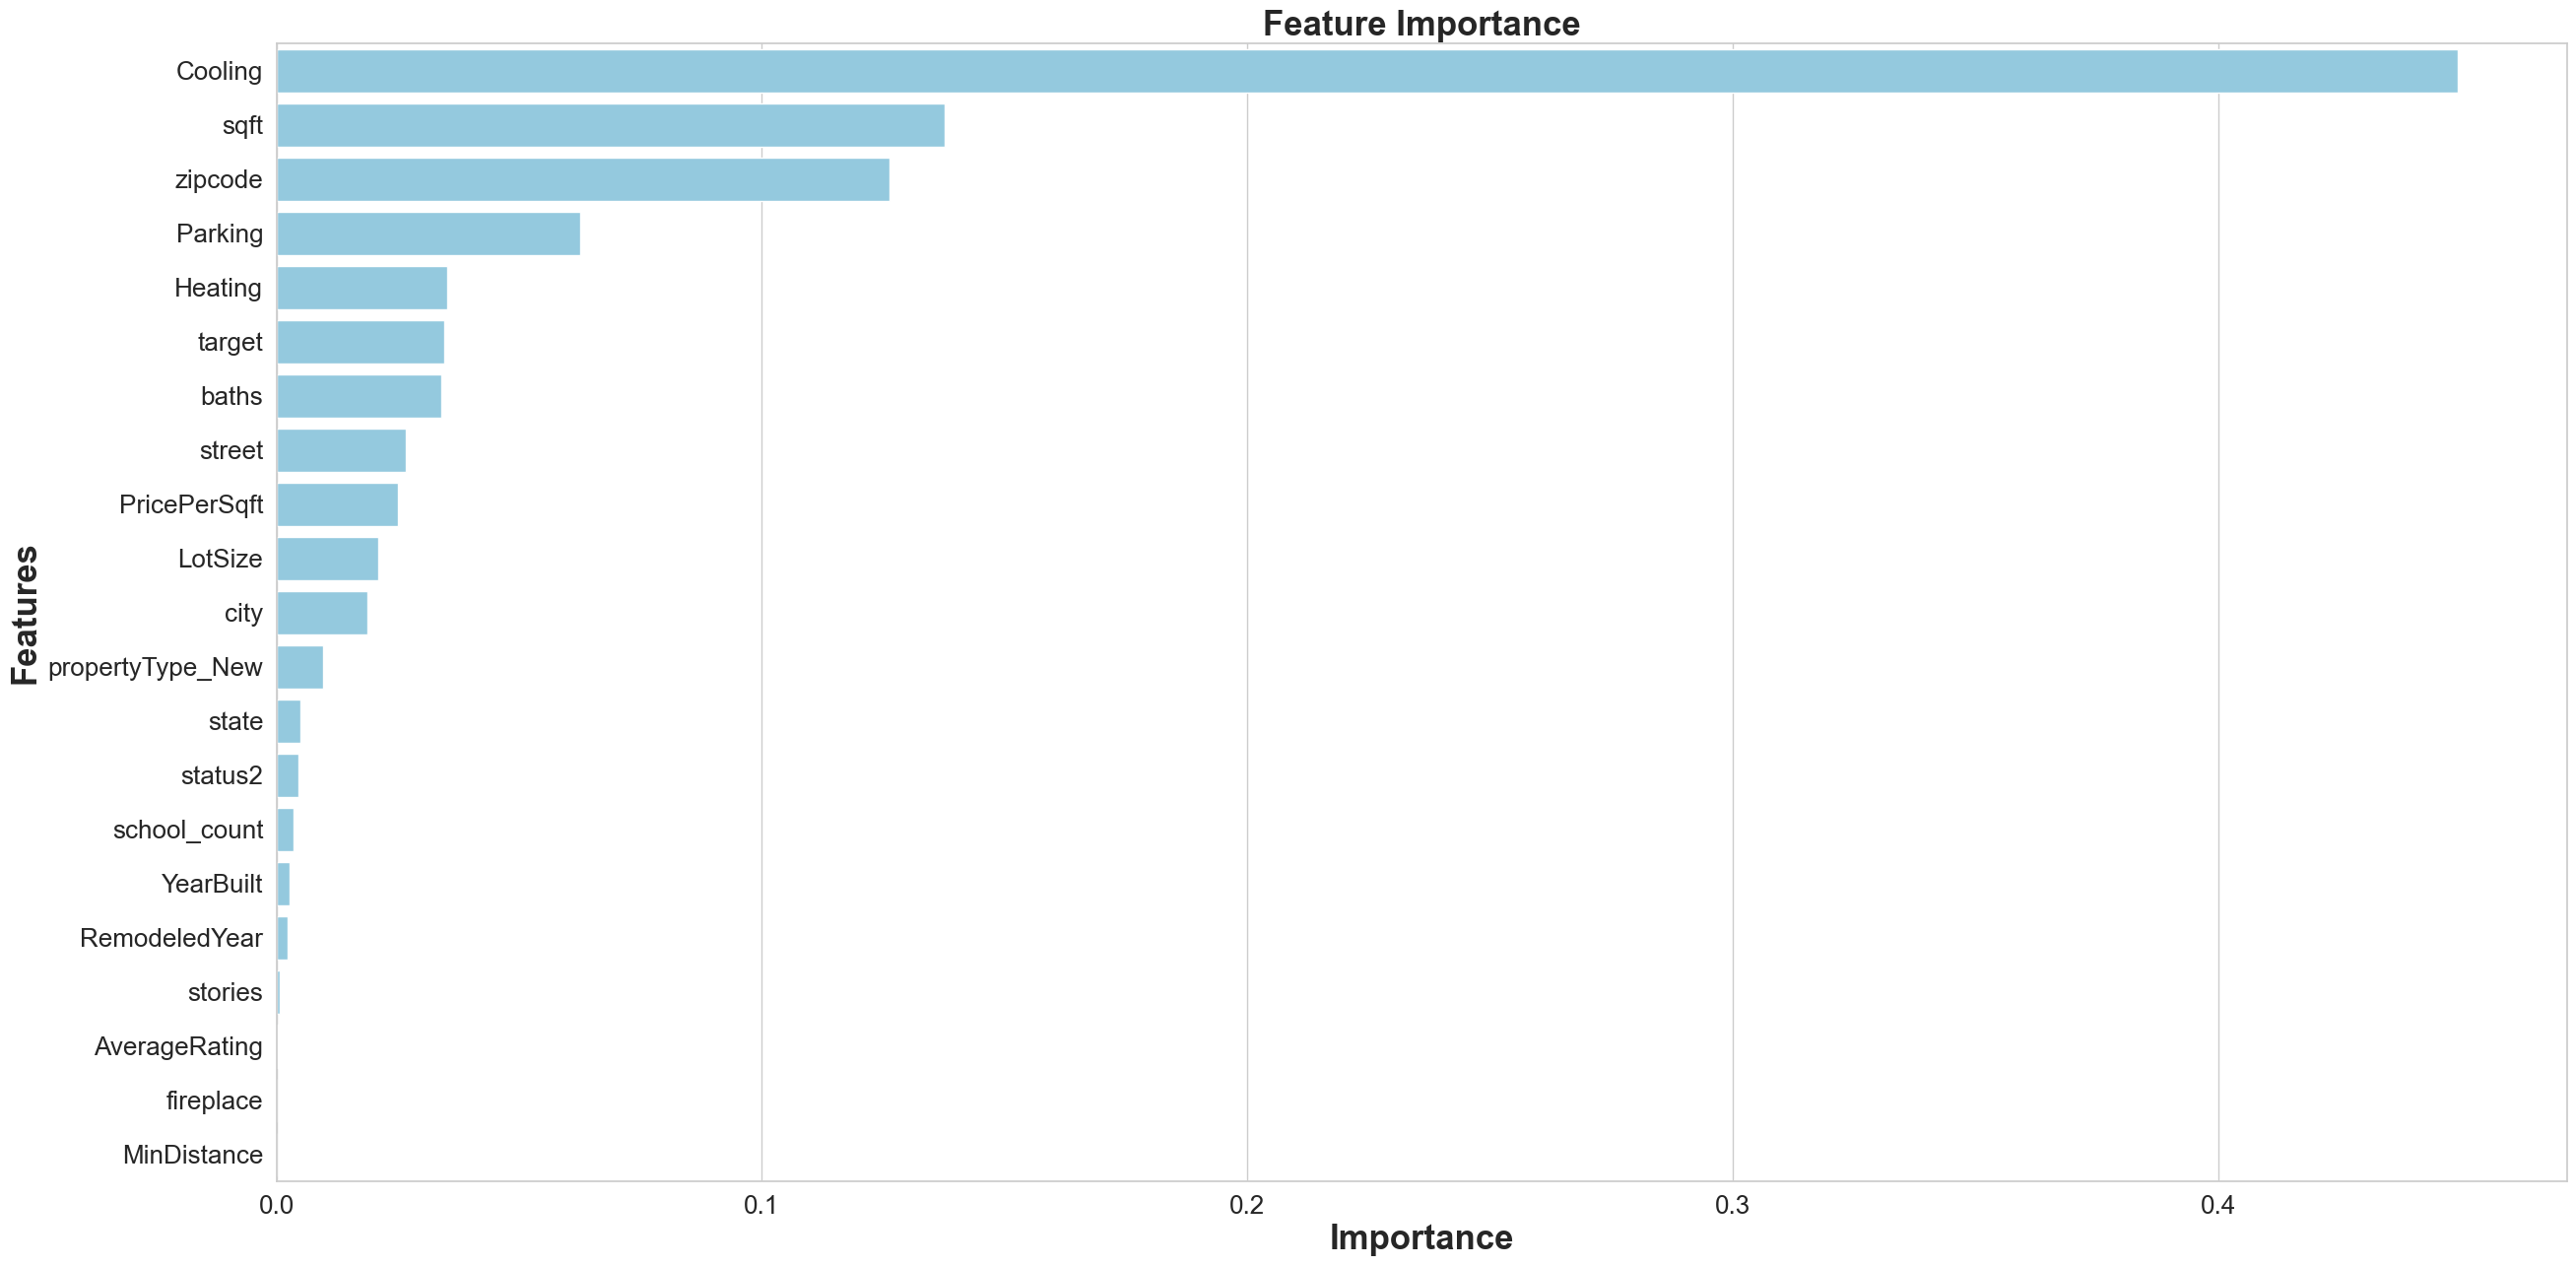

None

,Features,Gini-Importance
0,Cooling,0.449323
1,sqft,0.137714
2,zipcode,0.126246
3,Parking,0.062531
4,Heating,0.035151
5,target,0.034578
6,baths,0.034013
7,street,0.026780
8,PricePerSqft,0.025137
9,LotSize,0.021024


In [121]:
feats = {}
for feature, importance in zip(data.columns, random_forest_reg.feature_importances_):
    feats[feature] = importance
importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-Importance'})
importances = importances.sort_values(by='Gini-Importance', ascending=False)
importances = importances.reset_index()
importances = importances.rename(columns={'index': 'Features'})
sns.set_theme(font_scale = 5)
sns.set_theme(style="whitegrid", color_codes=True, font_scale = 1.7)
fig, ax = plt.subplots()
fig.set_size_inches(30,15)
sns.barplot(x=importances['Gini-Importance'], y=importances['Features'], data=importances, color='skyblue')
plt.xlabel('Importance', fontsize=25, weight = 'bold')
plt.ylabel('Features', fontsize=25, weight = 'bold')
plt.title('Feature Importance', fontsize=25, weight = 'bold')
display(plt.show())
display(importances)


График демонстрирует значимость отдельных характеристик в прогнозировании стоимости недвижимости при помощи модели random_forest. Особое внимание привлекает признак 'Cooling'. Характеристики 'sqft' и 'zipcode' также важны. 

In [128]:
# Обучаем с подобранными гиперпараметрами, и сравниваем с 'голой' моделью Random Forest Regression
n_estimators = 900
min_samples_split = 23
min_samples_leaf = 18 
max_features = 'log2'
max_depth = 30
bootstrap = False

model = RandomForestRegressor(n_estimators=n_estimators,
                              min_samples_split = min_samples_split,
                              min_samples_leaf = min_samples_leaf,
                              max_features = max_features,
                              max_depth = max_depth,
                              bootstrap = bootstrap)
model.fit(X_train, y_train)
y_pred_forest = model.predict(X_test)
mse_forest = mean_squared_error(y_test, y_pred_forest)
r2_sc_fr = r2_score(y_test, y_pred_forest)

print(f'MSE: {mse_forest:.2f} %')
print(f'R2: {r2_sc_fr:.2f}')

MSE: 0.14 %
R2: 0.87


Подбор гиперпараметров не улучшил точность прогнозирования. Можно использовать "голую" модель

## 5. Вэб-сервис

### pipeline

Создадим трансформеры для преобработки входных данных на сервер.

In [130]:
class StatusTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, mode_status='for sale'):
        self.patterns = {
            re.compile(r' / auction|.*Auction.*', re.IGNORECASE): 'Auction',
            re.compile(r'C|Option Contract.*', re.IGNORECASE): 'Contract',
            re.compile(r'.*(Conting|Ct|CT|Coming soon|Back on Market).*'): 'Contingent',
            re.compile(r"Pf|Pre-foreclosure.*", re.IGNORECASE): 'Pre Foreclosure',
            re.compile(r"(?i)Foreclos*"): 'Foreclosure',
            re.compile(r'New.*', re.IGNORECASE): 'New',
            re.compile(r'(?i).*pending.*|P|Active Option.'): 'Pending',
            re.compile(r'(?i)For sale.*'): 'for sale',
            re.compile(r'(?i).*Sold.*'): 'Sold',
            re.compile(r'Lease/*|Apartment for rent.*', re.IGNORECASE): 'for rent',
            re.compile(r'(?i).*Backup.*|Accepted|Uc|U\sUnder\sContract|.*Under.*'): 'Under Contract',
            re.compile(r'(?i).*activ.*|Re activated.*'): 'Active'
        }
        self.mode_status = mode_status

    def fit(self, X, y=None):
        # Здесь можно вычислить и сохранить любые значения, необходимые для трансформации
        # Но в данном случае mode_status уже установлен в __init__
        return self

    def transform(self, X, y=None):
        # Создаем копию DataFrame для безопасного преобразования
        X_transformed = X.copy()

        # Применение паттернов
        X_transformed['status2'] = X_transformed['status'].astype(str).apply(
            lambda x: next((replacement for pattern, replacement in self.patterns.items() if pattern.match(x)), x)
        )

        # Замена пустых значений на mode_status
        X_transformed['status2'].fillna(self.mode_status, inplace=True)
        X_transformed['status2'] = X_transformed['status2'].replace('nan', self.mode_status)

        # Удаляем исходный столбец 'status'
        X_transformed.drop(['status'], axis=1, inplace=True)

        return X_transformed

class StreetTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, mode_street='Address Not Disclosed'):
        self.mode_street = mode_street

    def fit(self, X, y=None):
        # В этом трансформере не требуется дополнительных вычислений при обучении,
        # так как mode_street уже установлен в __init__
        return self

    def transform(self, X, y=None):
        # Создаем копию DataFrame для безопасного преобразования
        X_transformed = X.copy()

        # Замена пропущенных значений на mode_street
        X_transformed['street'] = X_transformed['street'].fillna(self.mode_street)

        return X_transformed

class PropertyTypeTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.patterns = {
            r"(?i)\b(multi|condo|Condominium|Townhome|row home|co-op|coop|apartment|High Rise|Flat)\b": "multi-family",
            r"(?i)\b(Duplex|Triplex|Townhouse|townhouse|Cooperative|Penthouse|Bungalow|Multiple)\b": "multi-family",
            r"(?i)\b(Manufactured|Mfd|Mobile)\b": "Manufactured housing",
            r"(?i)\b(Single|story|Stories|transitional|Land|Ranch|Ranches|Contemporary|Colonial|Residential|Traditional|Garden Home|Cape Cod|Spanish|Mediterranean|Cluster Home|Florida|Tudor|SingleFamilyResidence|Craftsman|Cottage)\b": "one-to-four"
        }
        self.keywords = ["multi-family", "Manufactured housing", "one-to-four"]

    def transform(self, X, y=None):
        # Применение паттернов
        X['propertyType'] = X['propertyType'].replace(self.patterns, regex=True)

        # Создание нового признака
        X['propertyType_New'] = X['propertyType'].apply(
            lambda x: next((keyword for keyword in self.keywords
                            if re.search(keyword, str(x), re.IGNORECASE)), 'one-to-four')
        ).fillna('')

        # Удаление исходного столбца 'propertyType'
        X = X.drop(['propertyType'], axis=1)
        return X

    def fit(self, X, y=None):
        return self

class BathsTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        # Извлечение только целых чисел из признака 'baths'
        X['baths'] = X['baths'].str.extract(r'(\d+)').astype(float)

        # Замена всех пустых значений на 0
        X['baths'].fillna(0, inplace=True)

        # Преобразование типа данных на целочисленный
        X['baths'] = X['baths'].astype(int)
        return X

class CityStateTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        # Словарь для сопоставления штатов и модальных городов
        self.state_to_city = {
            'AL': 'Bryant', 'AZ': 'Glendale', 'BA': 'Unknown', 'CA': 'Los Angeles',
            'CO': 'Denver', 'DC': 'Washington', 'DE': 'Playa', 'FL': 'Miami',
            'Fl': 'Tamarac', 'GA': 'Atlanta', 'IA': 'Clear Lake', 'IL': 'Chicago',
            'IN': 'Indianapolis', 'KY': 'Hazard', 'MA': 'Boston', 'MD': 'Bethesda',
            'ME': 'Fairfield', 'MI': 'Detroit', 'MO': 'Saint Louis', 'MS': 'Cleveland',
            'MT': 'Fairfield', 'NC': 'Charlotte', 'NJ': 'Lakewood', 'NV': 'Las Vegas',
            'NY': 'Brooklyn', 'OH': 'Cleveland', 'OK': 'Cleveland', 'OR': 'Portland',
            'OS': 'Foreign Country', 'OT': 'Other', 'PA': 'Philadelphia',
            'SC': 'Fort Mill', 'TN': 'Nashville', 'TX': 'Houston', 'UT': 'Salt Lake City',
            'VA': 'Arlington', 'VT': 'Fairfax', 'WA': 'Seattle', 'WI': 'Milwaukee'
        }

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        # Создаем копию DataFrame для безопасного преобразования
        X_transformed = X.copy()

        # Заполняем пропущенные значения ������ородов на основе штата
        X_transformed['city'] = X_transformed.apply(
            lambda row: self.state_to_city[row['state']] if pd.isna(row['city']) else row['city'], axis=1
        )

        return X_transformed

class HomeFactsTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        # Десериализация содержимого признака 'homeFacts'
        X['homeFacts'] = X['homeFacts'].apply(ast.literal_eval)

        # Создание новых признаков на основе десериализованных значений
        X['YearBuilt'] = X['homeFacts'].apply(lambda x: x['atAGlanceFacts'][0]['factValue'])
        X['RemodeledYear'] = X['homeFacts'].apply(lambda x: x['atAGlanceFacts'][1]['factValue'])
        X['Heating'] = X['homeFacts'].apply(lambda x: x['atAGlanceFacts'][2]['factValue'])
        X['Cooling'] = X['homeFacts'].apply(lambda x: x['atAGlanceFacts'][3]['factValue'])
        X['Parking'] = X['homeFacts'].apply(lambda x: x['atAGlanceFacts'][4]['factValue'])
        X['LotSize'] = X['homeFacts'].apply(lambda x: x['atAGlanceFacts'][5]['factValue'])
        X['PricePerSqft'] = X['homeFacts'].apply(lambda x: x['atAGlanceFacts'][6]['factValue'])

        # Удаление старого столбца 'homeFacts'
        return X.drop(['homeFacts'], axis=1)

class CustomFeaturesTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.values_to_replace_year_built = ['', '559990649990', 'No', '1', 'No Data']
        self.values_to_replace_heating_cooling_parking = ['', 'No Data', 'None']

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        # Обработка YearBuilt
        X['YearBuilt'] = np.where(X['YearBuilt'].isin(self.values_to_replace_year_built), None, X['YearBuilt'])

        # Обработка RemodeledYear
        X['RemodeledYear'] = np.where(X['RemodeledYear'] == 0, np.nan, X['RemodeledYear']).astype('object')

        # Обработка Heating, Cooling, Parking
        X['Heating'] = X['Heating'].replace(self.values_to_replace_heating_cooling_parking, 0).replace('[^0]', 1, regex=True).fillna(0).astype(int)
        X['Cooling'] = X['Cooling'].replace(self.values_to_replace_heating_cooling_parking, 0).replace('[^0]', 1, regex=True).fillna(0).astype(int)
        X['Parking'] = X['Parking'].replace(self.values_to_replace_heating_cooling_parking, 0).replace('[^0]', 1, regex=True).fillna(0).astype(int)

        # Извлечение чисел из LotSize и PricePerSqft
        X['LotSize'] = X['LotSize'].str.extract('(\d+.\d+|\d+)', expand=False)
        X['PricePerSqft'] = X['PricePerSqft'].str.extract('(\d+.\d+|\d+)', expand=False)

        return X

class SchoolsTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        # Десериализация содержимого 'schools'
        X['schools'] = X['schools'].apply(ast.literal_eval)

        # Создание новых признаков
        X['rating'] = X['schools'].apply(lambda x: x[0]['rating'])
        X['Distance'] = X['schools'].apply(lambda x: x[0]['data']['Distance'])
        X['name_school'] = X['schools'].apply(lambda x: x[0]['name'])
        X['school_count'] = X['name_school'].apply(len)

        # Расчет суммы расстояний и средней дистанции до школ
        X['sum_distance'] = X['Distance'].apply(lambda x: sum(float(re.findall(r'\d+\.\d+', val)[0]) for val in x if re.findall(r'\d+\.\d+', val)) if x and any(re.findall(r'\d+\.\d+', val) for val in x) else None)
        X['Avr_distance'] = X['sum_distance'] / X['school_count']
        X['MinDistance'] = X['Distance'].apply(lambda x: min(float(re.findall(r'\d+\.\d+', val)[0]) for val in x if re.findall(r'\d+\.\d+', val)) if x and any(re.findall(r'\d+\.\d+', val) for val in x) else None)

        # Вычисление среднего рейтинга
        X['AverageRating'] = X['rating'].apply(self.calculate_rating)

        # Удаление вспомогательных столбцов
        return X.drop(['sum_distance', 'schools', 'rating', 'Distance', 'name_school'], axis=1)

    def calculate_rating(self, row):
        ratings = []
        for val in row:
            if re.match(r'^[\d./]+$', val):
                val = re.sub(r'/10$', '', val)
                try:
                    ratings.append(float(val))
                except ValueError:
                    pass
        return np.mean(ratings) if ratings else np.nan

class LotSizeSqftTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.sqft_median = 6.369  # Пример медианного значения, измените по необходимости

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        # Очистка и преобразование LotSize
        X['LotSize'] = X['LotSize'].str.replace(',', '.')
        X['LotSize'] = pd.to_numeric(X['LotSize'], errors='coerce')

        # Обработка sqft
        X['sqft'] = X['sqft'].apply(lambda x: re.sub(r'\D', '', str(x)))
        X['sqft'] = X['sqft'].replace('', np.nan).astype(float)
        X['sqft'].fillna(self.sqft_median, inplace=True)

        return X

class ZipcodeTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.zipcode_mode = 32137  # Пример значения по умолчанию

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        # Применение функции для извлечения числового значения из строки индекса
        X['zipcode'] = X['zipcode'].apply(self.extract_zipcode_number)

        # Замена значений '0' и '00000' на NaN и заполнение пропущенных значений модой
        X['zipcode'].replace({'0': np.nan, '00000': np.nan}, inplace=True)
        X['zipcode'].fillna(self.zipcode_mode, inplace=True)

        # Преобразование столбца в int64
        X['zipcode'] = X['zipcode'].astype('int64')

        return X

    @staticmethod
    def extract_zipcode_number(zipcode):
        match = re.match(r'^(\d+)-?', str(zipcode))
        return match.group(1) if match else np.nan

class BedsTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.median_beds_new = 3.0  # Пример значения по умолчанию

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        # Создание условного признака для фильтрации мусорных значений
        X['temp'] = X['beds'].astype(str).str.contains(r'acre|acres|sqft', case=False, regex=True).astype(int)

        # Создание нового признака 'beds_new'
        X['beds_new'] = X.apply(lambda row: self.extract_clean_beds(row['beds'], row['temp']), axis=1)

        # Удаление вспомогательных столбцов
        X = X.drop(['beds', 'temp'], axis=1)

        # Замена пропущенных значений на медиану
        X['beds_new'] = pd.to_numeric(X['beds_new'], errors='coerce').fillna(self.median_beds_new)

        return X

    @staticmethod
    def extract_clean_beds(beds, temp):
        if temp == 0:
            nums = str(beds).split()
            for num in nums:
                if num.isdigit():
                    return num
        return np.nan

class StoriesTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.stories_median = 1.0  # Устанавливаем значение медианы по умолчанию

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        # Паттерны для преобразования строк в числа
        patterns = {
            r"(?i)\b(One)\b": "1",
            r"(?i)\b(Two)\b": "2",
            r"(?i)\b(Three)\b": "3",
            r"(?i)\b(Four)\b": "4",
            r"(?i)\b(Five)\b": "5",
            # Другие паттерны по необходимости
        }

        # Создаем копию DataFrame для безопасного преобразования
        X_transformed = X.copy()

        # Применение паттернов к столбцу 'stories'
        X_transformed['stories'] = X_transformed['stories'].replace(patterns, regex=True)

        # Извлечение только числовых значений и преобразование в числа
        X_transformed['stories'] = X_transformed['stories'].apply(lambda x: re.sub(r'\D', '', str(x)))
        X_transformed['stories'] = pd.to_numeric(X_transformed['stories'], errors='coerce')

        # Замена пустых значений на медианное значение
        X_transformed['stories'].fillna(self.stories_median, inplace=True)

        return X_transformed

class CombinedMlsIDTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, mode_mlsID='NO MLS'):
        self.mode_mlsID = mode_mlsID

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        # Объединение 'MlsId' и 'mls-id' в 'mlsID'
        X_transformed = X.copy()
        X_transformed['mlsID'] = X_transformed['MlsId'].fillna(X_transformed['mls-id'])

        # Удаление исходных столбцов 'MlsId' и 'mls-id'
        X_transformed = X_transformed.drop(['MlsId', 'mls-id'], axis=1)

        # Замена пустых значений в 'mlsID' на заданный режим
        X_transformed['mlsID'].fillna(self.mode_mlsID, inplace=True)

        return X_transformed

class PoolTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        # Функция для преобразования значений
        replace_func = lambda x: '1' if x in ['Yes', 'yes'] else '0'

        # Применение функции к столбцам
        X['PrivatePool'] = X['PrivatePool'].map(replace_func)
        X['private pool'] = X['private pool'].map(replace_func)

        # Объединение значений в один столбец
        X['Private_Pool'] = np.where(X['PrivatePool'] == '1', X['PrivatePool'], X['private pool'])

        # Преобразование типа столбца 'Private_Pool' в int
        X['Private_Pool'] = X['Private_Pool'].astype(int)

        # Удаление исходных столбцов
        return X.drop(['PrivatePool', 'private pool'], axis=1)

class YearBuiltTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, median_year=1980):
        self.median_year = median_year

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X_transformed = X.copy()
        X_transformed['YearBuilt'] = pd.to_numeric(X_transformed['YearBuilt'], errors='coerce')
        X_transformed['YearBuilt'].fillna(self.median_year, inplace=True)
        X_transformed['YearBuilt'] = X_transformed['YearBuilt'].astype(int)
        return X_transformed
        
class RemodeledYearTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        # Инициализация не требуется
        pass

    def fit(self, X, y=None):
        # Подгонка не требуется
        return self

    def transform(self, X, y=None):
        # Преобразование пустых строк и строк с нулем в np.nan
        X_transformed = X.copy()
        X_transformed['RemodeledYear'] = X_transformed['RemodeledYear'].replace('', np.nan).replace('0', np.nan)
        
        # Преобразование в числовой тип
        X_transformed['RemodeledYear'] = pd.to_numeric(X_transformed['RemodeledYear'], errors='coerce')
        
        # Замена np.nan на 0, если это предпочтительное значение для отсутствующих данных
        X_transformed['RemodeledYear'].fillna(0, inplace=True)
        
        # Преобразование в целочисленный тип
        X_transformed['RemodeledYear'] = X_transformed['RemodeledYear'].astype(int)

        return X_transformed

class LotSizeTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, median_lot_size=6.369):
        self.median_lot_size = median_lot_size

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        # Создаем копию DataFrame для безопасного преобразования
        X_transformed = X.copy()

        # Преобразование в строковый тип и очистка данных
        X_transformed['LotSize'] = X_transformed['LotSize'].astype(str).str.replace(',', '').str.replace(' ', '')

        # Преобразование в числовой тип и заполнение пропущенных значений медианой
        X_transformed['LotSize'] = pd.to_numeric(X_transformed['LotSize'], errors='coerce').fillna(self.median_lot_size)

        return X_transformed

class PricePerSqftTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, mode=1.0):
        self.mode = mode

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        # Создаем копию DataFrame для безопасного преобразования
        X_transformed = X.copy()

        # Извлечение числовых значений из строк
        X_transformed['PricePerSqft'] = X_transformed['PricePerSqft'].astype(str).apply(lambda x: re.findall(r'\d+', x))
        X_transformed['PricePerSqft'] = X_transformed['PricePerSqft'].apply(lambda x: float(x[0]) if x else np.nan)

        # Замена пустых значений на моду
        X_transformed['PricePerSqft'].fillna(self.mode, inplace=True)
        
        return X_transformed

class AvrDistanceTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, median_avr_distance=1.7666):
        self.median_avr_distance = median_avr_distance

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        # Создаем копию DataFrame для безопасного преобразования
        X_transformed = X.copy()

        # Преобразование в числовой тип и заполнение пропущенных значений медианой
        X_transformed['Avr_distance'] = pd.to_numeric(X_transformed['Avr_distance'], errors='coerce').fillna(self.median_avr_distance)
        
        return X_transformed

class MinDistanceTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, median_min_distance=0.7):
        self.median_min_distance = median_min_distance

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        # Создаем копию DataFrame для безопасного преобразования
        X_transformed = X.copy()

        # Преобразование в числовой тип и заполнение пропущенных значений медианой
        X_transformed['MinDistance'] = pd.to_numeric(X_transformed['MinDistance'], errors='coerce').fillna(self.median_min_distance)

        return X_transformed

class AverageRatingTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, median_average_rating=5.0):
        self.median_average_rating = median_average_rating

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        # Создаем копию DataFrame для безопасного преобразования
        X_transformed = X.copy()

        # Преобразование значения среднего рейтинга, заполнение пустых значений медианным значением
        X_transformed['AverageRating'] = pd.to_numeric(X_transformed['AverageRating'], errors='coerce')
        X_transformed['AverageRating'].fillna(self.median_average_rating, inplace=True)

        return X_transformed

class MlsIDFireplaceTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        # Преобразование 'mlsID'
        X['mlsID'] = X['mlsID'].apply(lambda x: 1 if pd.notnull(x) else 0)

        # Преобразование 'fireplace'
        replace_func = lambda x: '1' if x in ['', 'No', 'No Fireplace', 'None', 'Not Applicable'] else '0'
        X['fireplace'] = X['fireplace'].map(replace_func).astype(int)

        return X

class CategoricalEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, features_to_encode=None):
        self.features_to_encode = features_to_encode
        self.encoders = {}

    def fit(self, X, y=None):
        for col in self.features_to_encode:
            # Если данные не категориальные, преобразуем их в строки
            if not pd.api.types.is_categorical_dtype(X[col]):
                X[col] = X[col].astype(str)
            self.encoders[col] = LabelEncoder().fit(X[col])
        return self

    def transform(self, X, y=None):
        X_transformed = X.copy()
        for col, encoder in self.encoders.items():
            # Преобразование данных в строки, если они не категориальные
            if not pd.api.types.is_categorical_dtype(X[col]):
                X_transformed[col] = X[col].astype(str)
            X_transformed[col] = encoder.transform(X_transformed[col])
        return X_transformed

class FeatureDropper(BaseEstimator, TransformerMixin):
    def __init__(self, features_to_drop=None):
        self.features_to_drop = features_to_drop

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X.drop(self.features_to_drop, axis=1, errors='ignore')

class StandardScalerTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.scaler = StandardScaler()

    def fit(self, X, y=None):
        # Обучаем StandardScaler на данных X
        self.scaler.fit(X)
        return self

    def transform(self, X, y=None):
        # Применяем масштабирование к данным X
        X_scaled = self.scaler.transform(X)
        return X_scaled


In [131]:
#не сработало
transformers = [
    ('status_transformer', StatusTransformer(mode_status='for sale')),
    ('street_transformer', StreetTransformer()),
    ('property_type_transformer', PropertyTypeTransformer()),
    ('baths_transformer', BathsTransformer()),
    ('city_state_transformer', CityStateTransformer()),
    ('home_facts_transformer', HomeFactsTransformer()),
    ('custom_transformer', CustomFeaturesTransformer()),
    ('schools_transformer', SchoolsTransformer()),
    ('lotsize_sqft_transformer', LotSizeSqftTransformer()),
    ('zipcode_transformer', ZipcodeTransformer()),
    ('beds_transformer', BedsTransformer()),
    ('stories_transformer', StoriesTransformer()),
    ('combined_mls_id_transformer', CombinedMlsIDTransformer()),
    ('pool_transformer', PoolTransformer()),
    ('year_built_transformer', YearBuiltTransformer()),
    ('remodeled_year_transformer', RemodeledYearTransformer()),
    ('lotsize_transformer', LotSizeTransformer()),
    ('price_per_sqft_transformer', PricePerSqftTransformer()),
    ('avr_distance_transformer', AvrDistanceTransformer()),
    ('min_distance_transformer', MinDistanceTransformer()),
    ('average_rating_transformer', AverageRatingTransformer()),
    ('mls_id_fireplace_transformer', MlsIDFireplaceTransformer()),
    ('feature_dropper', FeatureDropper(features_to_drop=['Avr_distance', 'target', 'Cooling', 'Parking'])),
    ('scaler', StandardScaler())
]

# Объединение всех трансформеров в один pipeline
preprocessing_pipeline = Pipeline(steps=transformers)

# Инициализация CategoricalEncoder с указанными признаками для кодирования
categorical_features = ['city', 'street', 'state', 'status2', 'propertyType_New']
categorical_transformer = CategoricalEncoder(features_to_encode=categorical_features)

from sklearn.compose import ColumnTransformer
# Добавление CategoricalEncoder в pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough'  # Остальные признаки не изменяются
)

# Сборка полного pipeline
full_pipeline = Pipeline(steps=[
    ('preprocessing', preprocessing_pipeline),
    ('categorical', preprocessor),
    ('scaler', StandardScaler())
])

In [132]:
# Обучаем StandardScaler
import pickle
scaler = StandardScalerTransformer()
X_scaled = scaler.fit(X)

# Сохраним в файл обученный трансформер
with open('scaler2.pkl', 'wb') as f:
    pickle.dump(scaler, f)

### Flask приложение

In [135]:
# Сериализация модели в файл
with open('model.pkl', 'wb') as file:
    pickle.dump(model, file)

In [136]:
# Производим десериализацию и извлекаем модель из файла формата pkl
import pickle
with open('model.pkl', 'rb') as pkl_file:
    model = pickle.load(pkl_file)

model

RandomForestRegressor(bootstrap=False, max_depth=30, max_features='log2',
                      min_samples_leaf=18, min_samples_split=23,
                      n_estimators=900)